# Práctica 1 - Self-Organising Maps
## Preparación de entorno
#### Instalar las librerías

In [11]:
# %pip install numpy
# %pip install matplotlib

#### Importar librerías de código

In [12]:
%reset
# from __future__ import division

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches

# Permite que los gráficos sean interactivos en el notebook
%matplotlib inline

## SOM Setup
* **SOM** $\rightarrow$ Red neuronal no supervisada que reduce la dimensionalidad de los datos y los visualiza en un mapa 2D (Mapa autoorganizado).
  * Vector de entrada $\rightarrow$ Se le va presentando al SOM y ajusta sus pesos con estos vectores.
  * Autoorganización $\rightarrow$ Las neuroinas que repsonden de forma siilar a cierta entrada se agrupan.
  * Aprendizaje y ajuste $\rightarrow$ Durante el entrenamiento, la red modifica los donde cada mapa se especializa en un patrón específico.
* **Matriz de pesos** $\rightarrow$ Matriz multidimensionl de neuronas que procesea patrones que vienen de un array de neuronas de entrada. 
  * Se inicializa con valores aleatorios (no a partir del vector de entrada, si no que se van ajustando a lo largo del entrenamiento).
* ***Best Matching Unit (BMU)*** $\rightarrow$ Neurona que tiene el vector de pesos más similar al vector de entrada. 
  * El aprendizaje se basa en la actualización de los pesos de la BMU y de las neuronas vecinas. 
  * Los pesos de la BMU se ajustan/actualizan para acercarse al vector de entrada.
* **Vecindad** $\rightarrow$ Neuronas adyacentes a la BMU (es una región de la matriz de pesos).
  * Las neuronas de la vecindad también se ajustan, pero en menor medida que la BMU.
* ***Learning Rate (LR)*** $\rightarrow$ Factor que determina cuánto se ajustan los pesos de la BMU y de las neuronas vecinas.
  * Se reduce a lo largo del tiempo para que el ajuste sea más preciso.
  * Disminuye a medida que nos alejamos de la BMU.

> *Nota* - El SOM aprende a ordenar la matriz de pesos para que reperesente la estructura inherente a los datos de entrada.

In [13]:
lado_mapa = 50
"""Tamaño del mapa de Kohonen (lado_mapa x lado_mapa)"""

periodo = 5000
"""Número total de iteraciones del entrenamiento"""

learning_rate = 0.15
"""Tasa de aprendizaje inicial (cuanto se modifica el peso en cada iteración)"""

normalizar_datos = True
"""Indica si hay que normalizar los datos o no"""

num_entradas = 3
"""Dimensionalidad de los datos de entrada (3 para RGB)"""

num_datos = 100
"""Cantidad de muestras de colores que usaremos para entrenar el SOM"""

valor_maximo = 255
"""Valor máximo de los datos de entrada (255 para RGB)"""

vecindario = lado_mapa // 2
"""Radio de influenia alrededor de la neurona ganadora"""

# Estructura -> minimo, maximo, (numero de colores por dato, numero de datos))
datos = np.random.randint(0, valor_maximo + 1, (num_entradas, num_datos))
"""Matriz de 100 colores con 3 valores RGB aleatorios"""

if normalizar_datos:
    # Escalamos los datos al rango [0, 1]
    datos = datos / np.max(valor_maximo)

matriz_pesos = np.random.random((lado_mapa, lado_mapa, num_entradas))
"""Matriz de pesos de las neuronas"""

'Matriz de pesos de las neuronas'

#### Funciones para entrenar/clasificar
##### Distancia euclídea

La distancia euclídea se define como la raíz cuadrada de la suma de las diferencias al cuadrado de cada componente de los vectores. Tenemos que calcularlo para vectores RGB, por lo que la fórmula es la siguiente:
$$\text{distancia euclídea} = \sqrt{(R_{entrada} - R_{actual})^2 + (G_{entrada} - G_{actual})^2 + (B_{entrada} - B_{actual})^2}$$

In [14]:
def calcular_bmu(patron_entrada, matriz_pesos, num_entradas) -> tuple:
   """Encuentra la BMU (neurona ganadora) para un patrón de entrada.

   Args:
      patron_entrada: Vector de entrada de color RGB normalizado
      matriz_pesos: Matriz de pesos de las neuronas del SOM
      num_entradas: Dimensionalidad de los datos de entrada (3 para RGB)

   Returns:
      tuple (bmu, bmu_idx):
         - bmu: vector de pesos de la neurona ganadora
         - bmu_idx: coordenadas [x,y] de la neurona ganadora
   """

   distancia_minima = float('inf')
   bmu = np.zeros(num_entradas)
   bmu_idx = np.zeros(2)

   # Recorremos cada neurona para encontrar la BMU
   # Filas -> matriz_pesos.shape[0]
   # Columnas -> matriz_pesos.shape[1]
   for fila in range(matriz_pesos.shape[0]):
      for columna in range(matriz_pesos.shape[1]):
         peso_actual = matriz_pesos[fila, columna]

         # Calculamos la distancia euclídea entre el peso actual y el patrón de entrada
         distancia = np.linalg.norm(patron_entrada - peso_actual)

         if distancia < distancia_minima:
            distancia_minima = distancia
            bmu = peso_actual
            bmu_idx = np.array([fila, columna])

   return bmu, bmu_idx

##### Learning Rate

El learning rate es un valor que se va reduciendo a medida que se va entrenando la red. Controla cuánto se modifican los pesos y determina el temaño del ajuste en los pesos de las neuronas. Se calcula usando una función de decaimiento lineal:
$$\alpha(t) = \alpha_0 \cdot \left ( 1 - \frac{t}{T} \right)$$

Donde:
* $\alpha_0$: Learning rate inicial.
* $t$: Iteración actual.
* $T$: Número total de iteraciones.
* $\alpha(t)$: Learning rate en la iteración $t$.

¿Porque usamos el decaimiento lineal?:
1. **Fase inicial:**
   * El learning rate comienza en su valor máximo ($\alpha_0$).
   * La reducción es constante y predecible.
   * Los ajustes son proporcionalmente grandes.
   * Permite que hagamos modificaciones significativas en el mapa.
2. **Fase media:**
    * Descenso uniforme del learning rate.
    * Los cambios en los pesos son más pequeños.
    * Los ajustes son proporcionales al tiempo que ha pasado.
    * El mapa comienza a estabilizarse.
3. **Fase final:**
   * Learning rate se aproxima a 0.
   * Los ajustes se vuelven muy pequeños.
   * Los cambios son mínimos al final del entrenamiento.
   * El mapa tiene a una configuración final estable.


In [15]:
def variacion_learning_rate(learning_rate_inicial, iteracion_actual, num_iteraciones) -> float:
   """Calcula el Learning Rate (eta) para  la iteración actual utilizando el decaimiento lineal.

   Args:
      learning_rate_inicial: Learning rate inicial
      iteracion_actual: Iteración actual
      num_iteraciones: Número total de iteraciones

   Returns:
      float: Learning rate actualizado para la iteración actual
   """

   return learning_rate_inicial * ( 1 - (iteracion_actual / num_iteraciones))

##### Vecindario

El vencindario es una región de influencia alrededor de la neurona ganadora que determina qué otrsa neuronas se actualizarán y en que medida. Es como una zona de impacto y también se calcula usando la función de decaimiento lineal:
$$\sigma(t) = 1 + \left ( \sigma_0 \cdot \left (1 - \frac{t}{T} \right) \right)$$

Donde:
* $\sigma_0$: Radio inicial del vecindario.
* $t$: Iteración actual.
* $T$: Número total de iteraciones.
* $\sigma(t)$: Radio del venciandario en la iteración $t$.

> *Nota* -> Añadimos el 1 para evitar que el radio del vecindario sea 0 en algún momento.

¿Porque usamos el decaimiento lineal?:
1. **Fase inicial:**
   * El vecindario comienza en su valor máximo ($\sigma_0$).
   * Afecta a un gran número de neuronas vecinas.
   * Permite que hagamos una organización global del mapa.
   * Facilita que distribuyamos inicialmente las características.
2. **Fase media:**
    * Reducimos constantemente el radio del vecindario.
    * Vamos disminuyendo la influencia gradualmente.
    * Formamos estructuras locales más definidas.
    * Los ajustes son más precisos y específicos.
3. **Fase final:**
   * El radio del vecindario se acerca linelamente a 0.
   * Los ajustes son en un área muy pequeña.
   * Se ajustan los últimos detalles.
   * La influencia está practicamente limitada a la BMU.


In [16]:
def variacion_vecindario(vecindario_inicial, iteracion_actual, num_iteraciones) -> float:
   """Calcula el radio del vecindario para la iteración actual.

   Args:
      vecindario_inicial: Radio inicial del vecindario
      iteracion_actual: Iteración actual
      num_iteraciones: Número total de iteraciones

   Returns:
      float: Vecindario actualizado para la iteración actual
   """

   return 1 + (vecindario_inicial * ( 1 - (iteracion_actual / num_iteraciones)))

##### Decay (Amortiguación)

El decay es una función que determina cómo se amortigua el learning rate según la distancia entre una neurona y la BMU (neurona ganadora). Se calcula usando una función gaussiana:

$$h(d,\sigma) = e^{-\frac{d^2}{2\sigma^2}}$$

Donde:
* $d$: Distancia entre la neurona y la BMU
* $\sigma$: Radio actual del vecindario
* $h(d,\sigma)$: Factor de amortiguación

¿Por qué usamos una función gaussiana?:
1. **Centro (BMU)**:
   * Distancia = 0
   * Máxima influencia ($\approx 1$)
   * Mayor ajuste de pesos

2. **Neuronas cercanas**:
   * Distancia pequeña
   * Influencia moderada
   * Ajuste proporcional a la cercanía

3. **Neuronas lejanas**:
   * Distancia grande
   * Influencia mínima ($\approx 0$)
   * Casi no se modifican

In [17]:
def decay(distancia_BMU, vecindario_actual) -> float:
   """Calcula la amortiguación de eta en función de la distancia en el mapa entre una neurona y la BMU.

   Args:
      distancia_BMU: Distancia entre la neurona y la BMU
      vecindario_actual: Radio actual del vecindario

   Returns:
      float: Factor de amortiguación para la iteración (Está entre 0 y 1)
   """
   return np.exp(-distancia_BMU / (2 * (vecindario_actual**2)))

#### Funciones para dibujar la salida de la red

In [24]:
def pintar_mapa(matriz_valores, titulo):
    """Función para pintar una matriz de valores como colores RGB.
    Visualiza el mapa de Kohonen, donde cada neurona se representa como un rectángulo de color RGB.

    Args:
        matriz_valores: Matriz de valores RGB (lado_mapa x lado_mapa x 3)
        titulo: Titulo del mapa
    """

    # Creamos una nueva figura
    fig = plt.figure()

    # Establecemos los ejes
    ax = fig.add_subplot(111, aspect='equal') # aspect='equal' mantiene cuadrados los rectángulos
    ax.set_xlim((0, matriz_valores.shape[0]+1)) # Limites del eje x
    ax.set_ylim((0, matriz_valores.shape[1]+1)) # Limites del eje y
    ax.set_title(titulo)

    # Dibujamos los rectángulos por cada neurona (Un cuadrado RGB)
    for fila in range(1, matriz_valores.shape[0] + 1):
        for columna in range(1, matriz_valores.shape[1] + 1):
            ax.add_patch(patches.Rectangle(
                (fila - 0.5, columna - 0.5),                           # Posición (x,y) del rectángulo
                1, 1,                                                  # Ancho y alto del rectángulo
                facecolor = matriz_valores[fila - 1, columna - 1, :],  # Color RGB del rectángulo
                edgecolor = 'none'                                     # Sin borde
            ))

    plt.show()

## SOM Entrenamiento

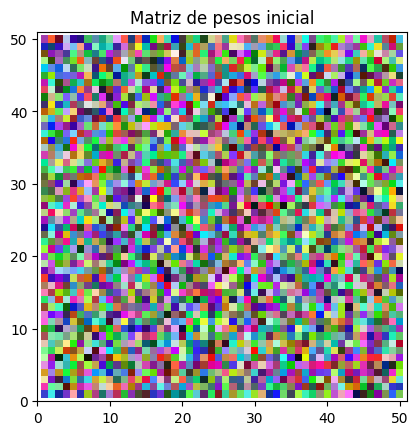

KeyboardInterrupt: 

In [ ]:
def entrenar_datos(matriz_pesos, periodo, datos, num_datos, num_entradas, learning_rate, vecindario) -> None:
    """Entrena el mapa de Kohonen con los datos de entrada.

    Args:
        matriz_pesos: Matriz de pesos de las neuronas del SOM
        periodo: Número total de iteraciones del entrenamiento
        datos: Datos de entrada (3 x num_datos)
        num_datos: Número de datos de entrada
        num_entradas: Dimensionalidad de los datos de entrada (3 para RGB)
        learning_rate: Tasa de aprendizaje inicial
        vecindario: Radio de influencia alrededor de la neurona ganadoras
    """

    # Pintamos la matriz de pesos inicial
    pintar_mapa(matriz_pesos, "Matriz de pesos inicial")

    # Entrenamiento del SOM
    for epoca in range(periodo):
        # Seleccionamos un patrón de entrada aleatorio
        patron_azar = datos[:, np.random.randint(0, num_datos)]

        # Buscamos la BMU para el patrón de entrada
        neurona_bmu, bmu_indice = calcular_bmu(patron_azar, matriz_pesos, num_entradas)

        # Calculamos los parámetros para esta iteración
        lr_actual = variacion_learning_rate(learning_rate, epoca, periodo)
        vec_actual = variacion_vecindario(vecindario, epoca, periodo)

        # Actualizamos el vector de pesos de la BMU y sus vecinos
        for fila in range(matriz_pesos.shape[0]):
            for columna in range(matriz_pesos.shape[1]):
                # Calculamos la distancia a la BMU
                distancia_bmu = np.linalg.norm([fila - bmu_indice[0], columna - bmu_indice[1]])

                if distancia_bmu <= vec_actual:
                    # Calculamos la amortiguación basada en la distancia
                    amortiguacion = decay(distancia_bmu, vec_actual)

                    # Actualizamos los pesos usando la fórmula
                    matriz_pesos[fila, columna] += lr_actual * amortiguacion * (patron_azar - matriz_pesos[fila, columna])

        if epoca % 100 == 0 and epoca != 0:
            # Pintamos la matriz de pesos
            pintar_mapa(matriz_pesos, f"Iteración: {epoca}")

entrenar_datos(matriz_pesos, periodo, datos, num_datos, num_entradas, learning_rate, vecindario)

#### Evaluación de los parámetros
Para evaluar los parámetros de la red, vamos a usar el conjunto de datos de entrenamiento y vamos a entrenar la red con diferentes valores de los parámetros. Vamos a usar la función de error cuadrático medio/cuadrático (MSE) y el error topológico para evaluar la calidad de la red. 
* **Error cuadrático medio (MSE)** $\rightarrow$ Mide la diferencia entre el vector de entrada y el vector de salida de la red.
* **Error topológico** $\rightarrow$ Mide la calidad de la representación topológica de la red. Se calcula como el número de veces que dos vectores que están cerca en el espacio de entrada no están cerca en el mapa.

Fórmula del error cuadrático medio: $$MSE = \frac{1}{N} \sum_{i=1}^{N} \left \| x_i - y_i \right \|^2$$

Fórmula del error topológico: $$TE = \frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{N} d_{ij} \cdot \delta_{ij}$$

Hemos dividido el proceso entre 4 personas para que cada uno se encargue de un rango.

```python
# Persona 1
rangos_persona1 = {
    'lado_mapa': [10, 20, 30],  # 3 valores
    'periodo': list(range(1000, 7001, 1000)),
    'learning_rate': [round(x/10, 1) for x in range(1, 6)]
}
# Total: 3 * 7 * 5 = 105 combinaciones

# Persona 2
rangos_persona2 = {
    'lado_mapa': [40, 50, 60],  # 3 valores
    'periodo': list(range(1000, 7001, 1000)),
    'learning_rate': [round(x/10, 1) for x in range(1, 6)]
}
# Total: 3 * 7 * 5 = 105 combinaciones

# Persona 3
rangos_persona3 = {
    'lado_mapa': [70, 80],  # 2 valores
    'periodo': list(range(1000, 7001, 1000)),
    'learning_rate': [round(x/10, 1) for x in range(1, 6)]
}
# Total: 2 * 7 * 5 = 70 combinaciones

# Persona 4
rangos_persona4 = {
    'lado_mapa': [90, 100],  # 2 valores
    'periodo': list(range(1000, 7001, 1000)),
    'learning_rate': [round(x/10, 1) for x in range(1, 6)]
}
# Total: 2 * 7 * 5 = 70 combinaciones
```

--- Rangos a evaluar: ---
Lados del mapa: [10, 20, 30]
Periodos: [1000, 2000, 3000, 4000, 5000, 6000, 7000]
Learning rates: [0.1, 0.2, 0.3, 0.4, 0.5]

 Vamos a evaluar 105 combinaciones de parámetros...

Combinación 1/105
Lado: 10, Periodo: 1000, Learning Rate: 0.1


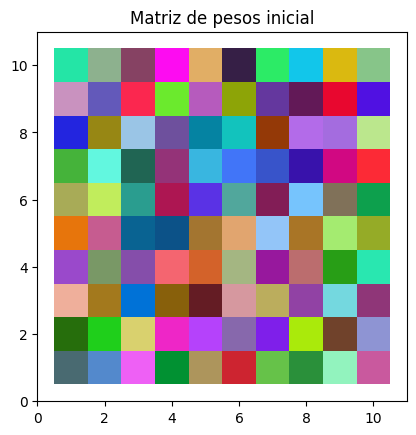

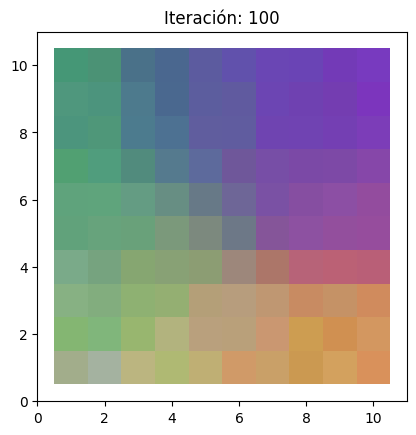

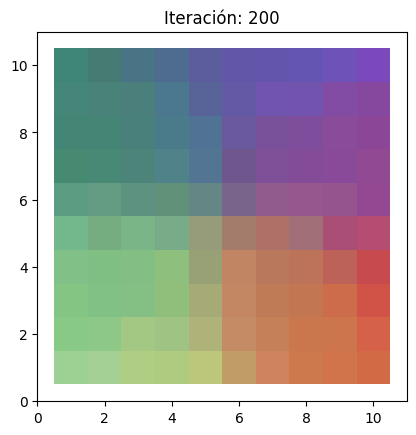

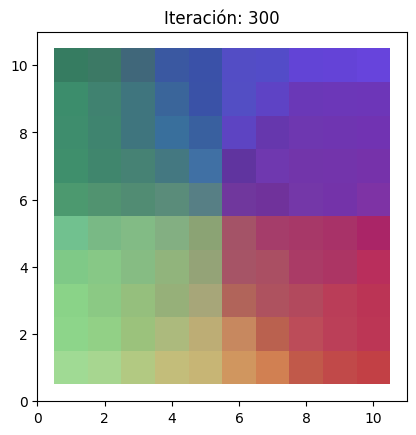

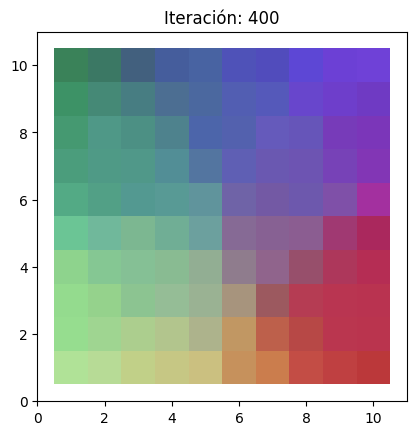

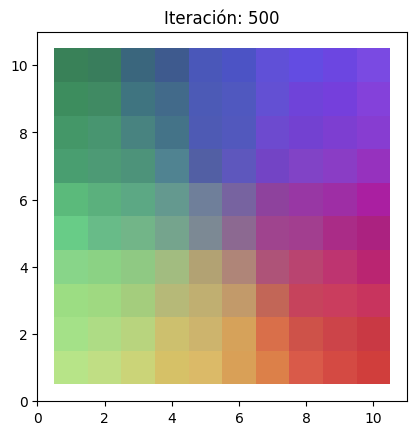

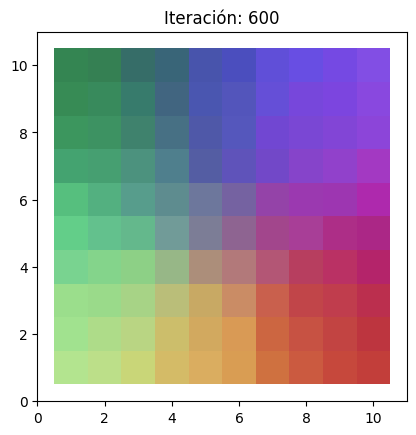

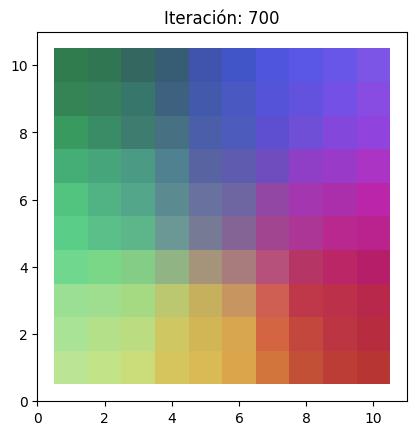

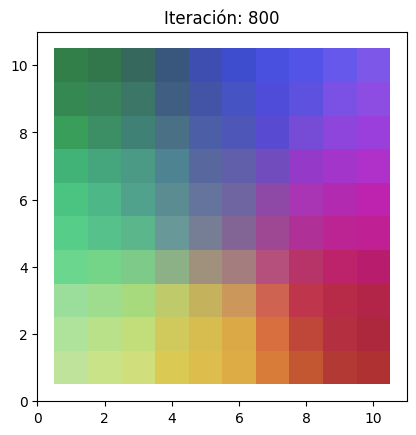

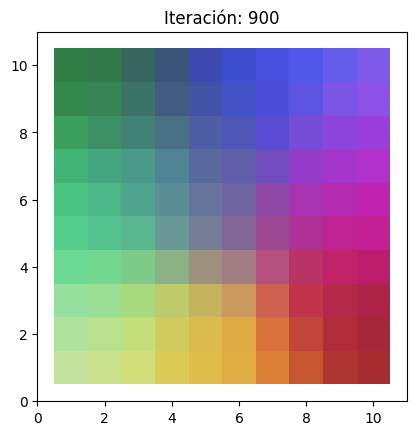

Error medio: 0.157939

Combinación 2/105
Lado: 10, Periodo: 1000, Learning Rate: 0.2


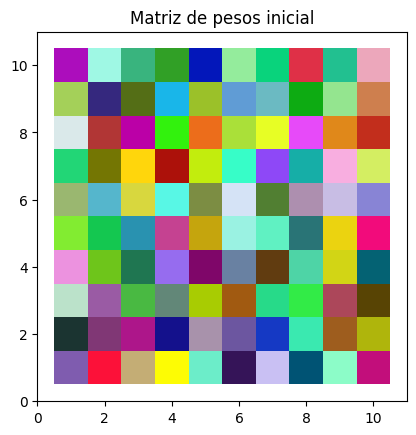

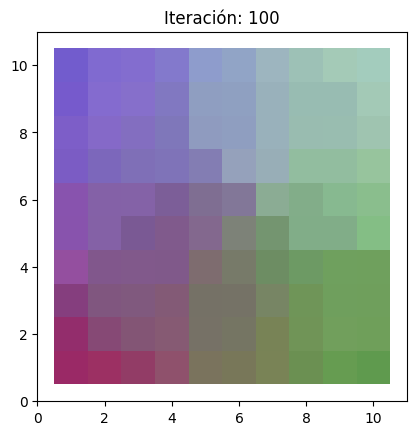

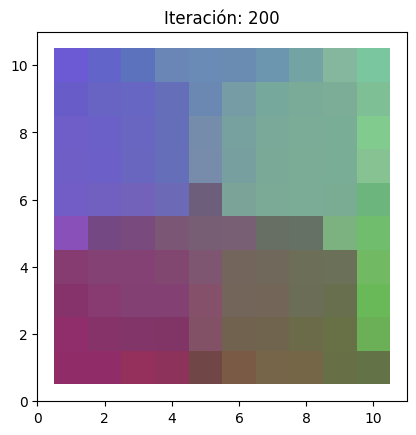

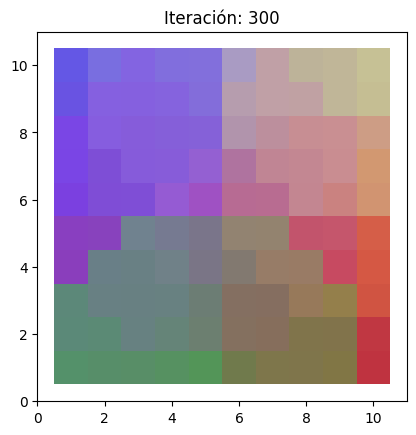

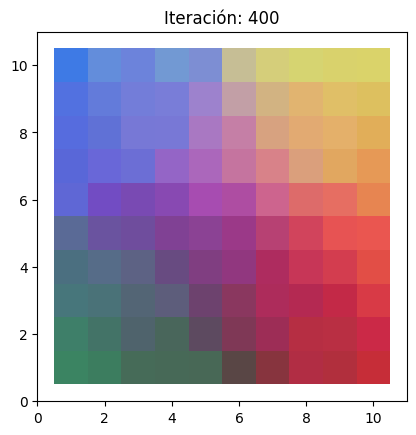

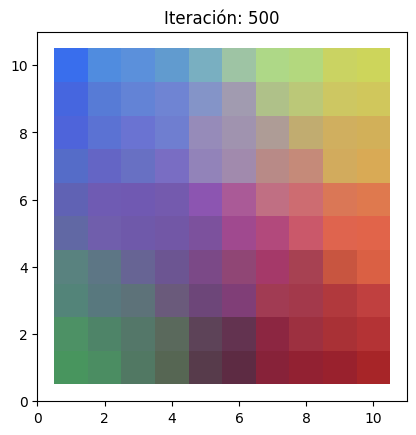

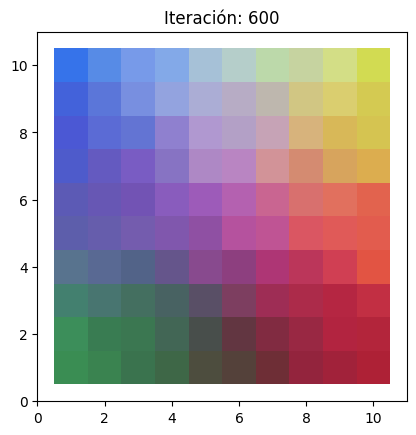

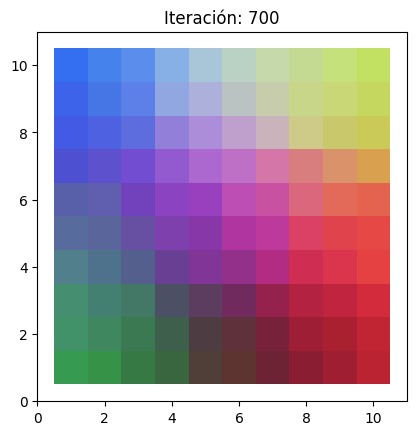

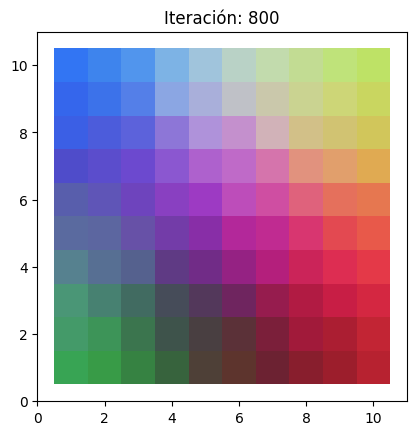

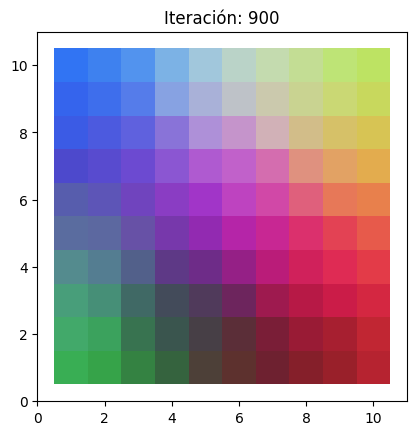

Error medio: 0.136401

Combinación 3/105
Lado: 10, Periodo: 1000, Learning Rate: 0.3


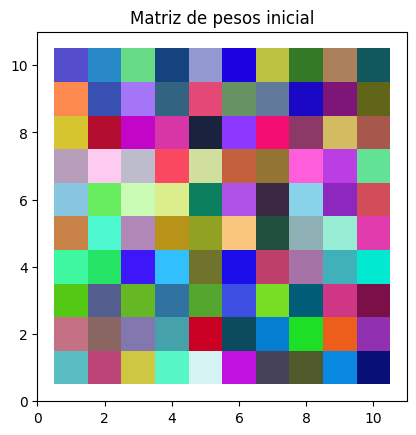

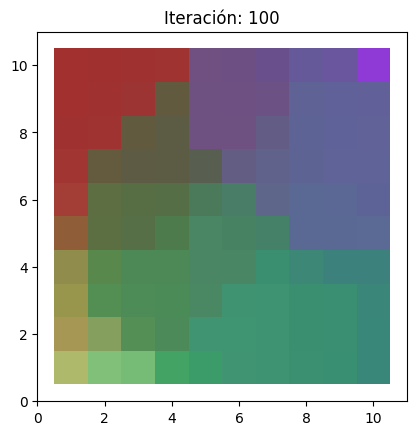

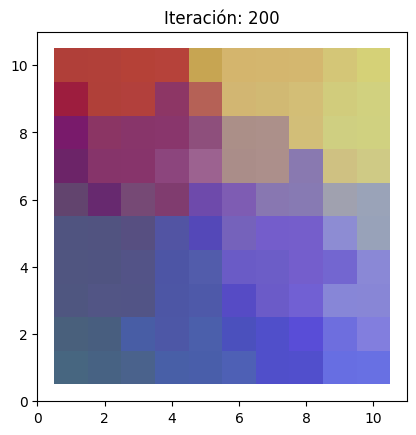

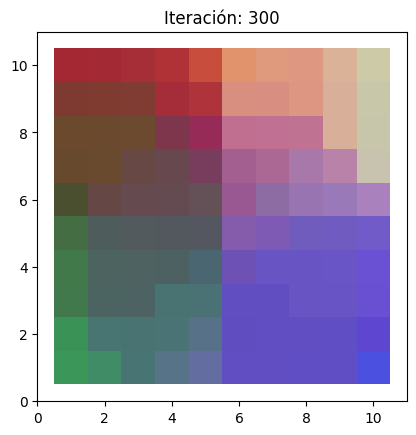

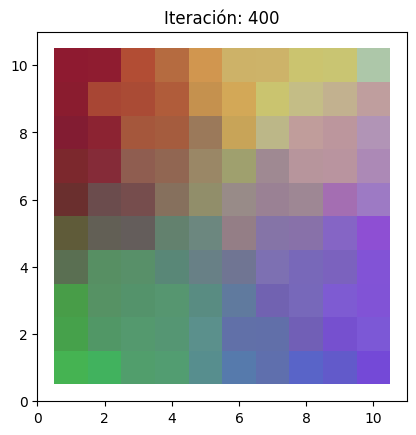

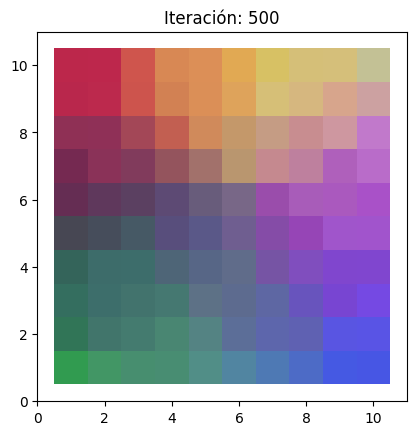

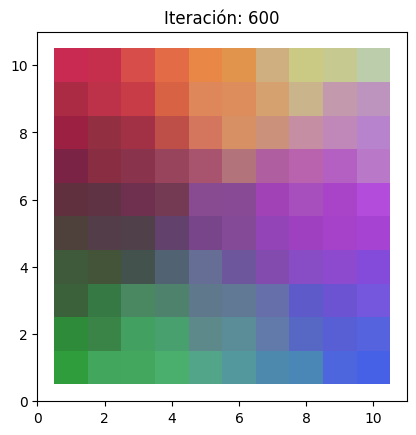

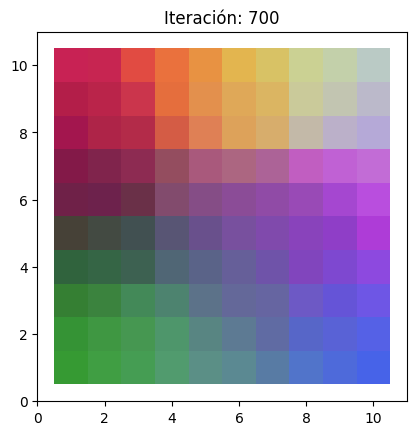

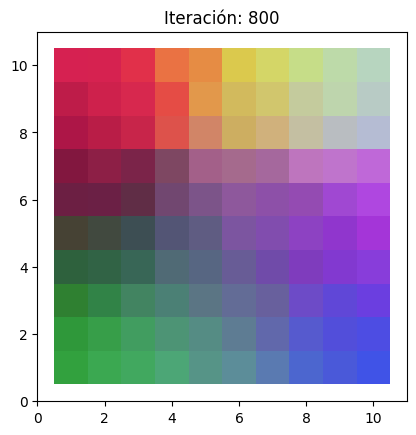

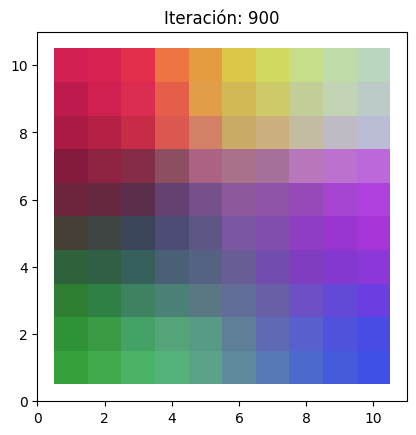

Error medio: 0.142989

Combinación 4/105
Lado: 10, Periodo: 1000, Learning Rate: 0.4


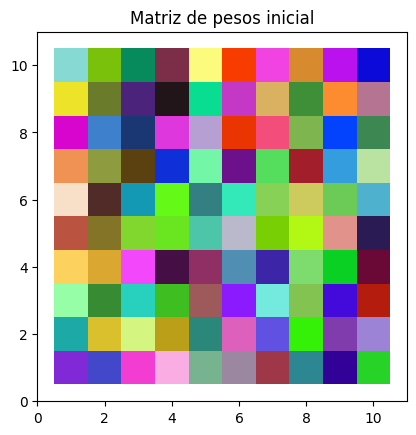

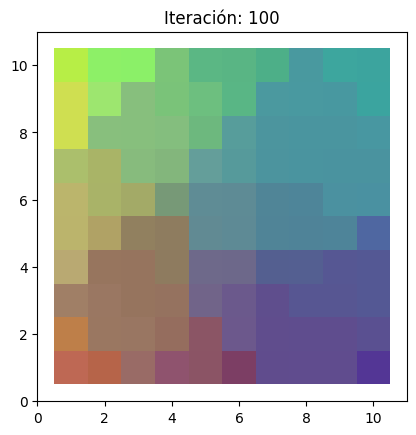

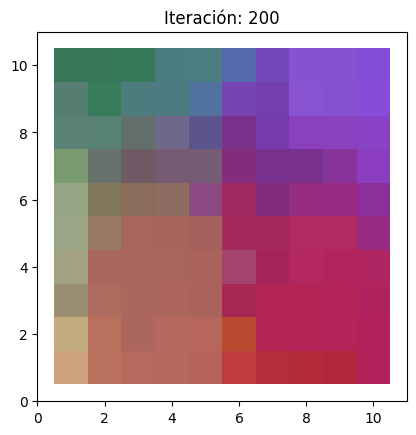

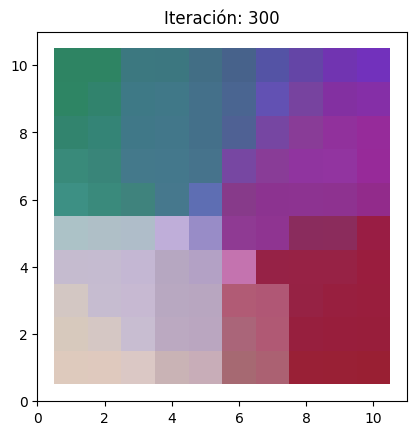

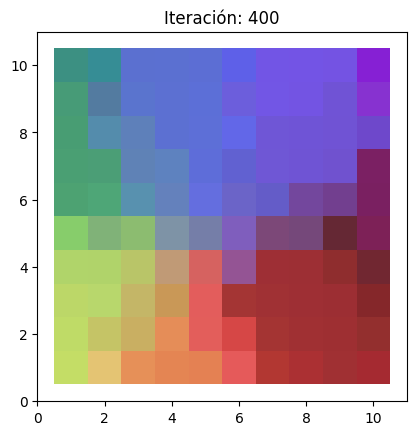

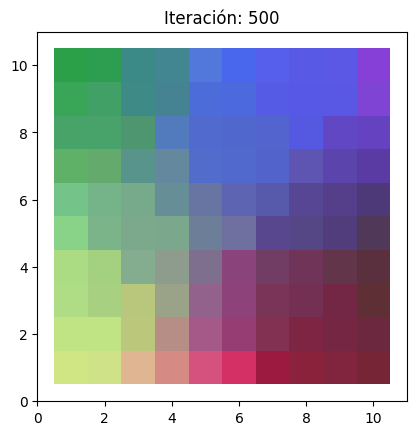

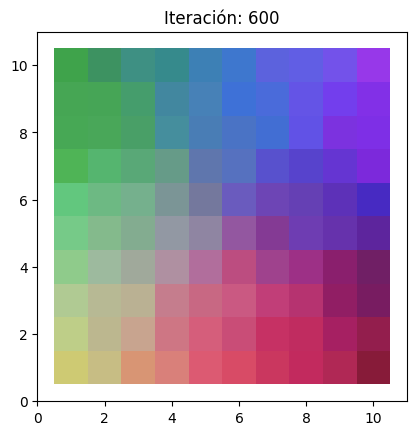

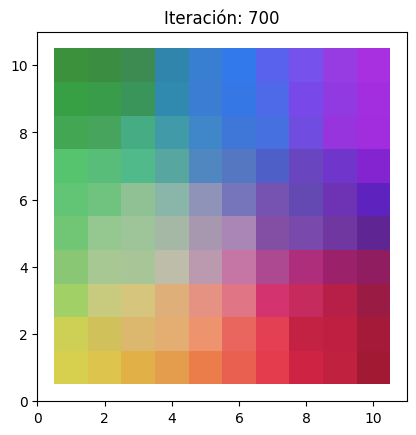

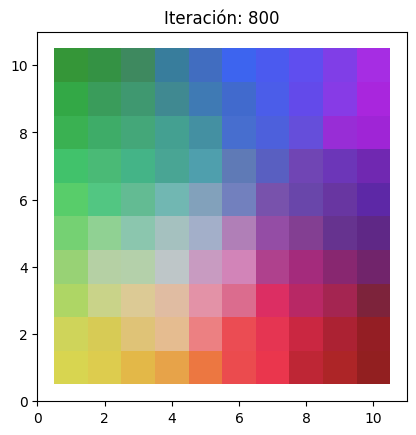

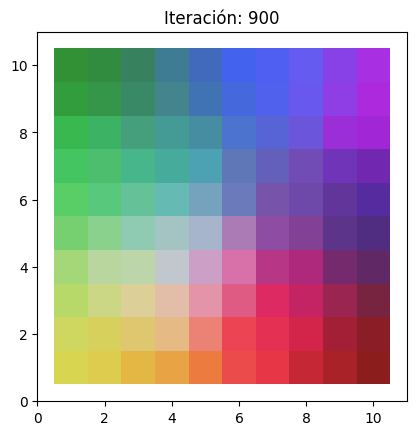

Error medio: 0.127891

Combinación 5/105
Lado: 10, Periodo: 1000, Learning Rate: 0.5


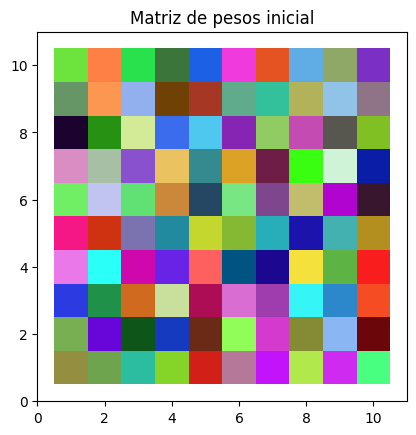

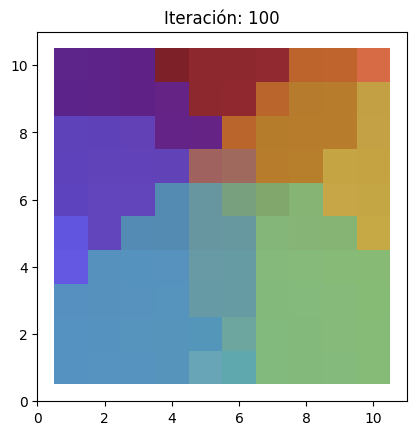

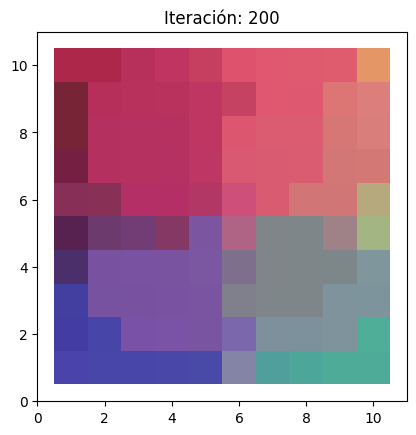

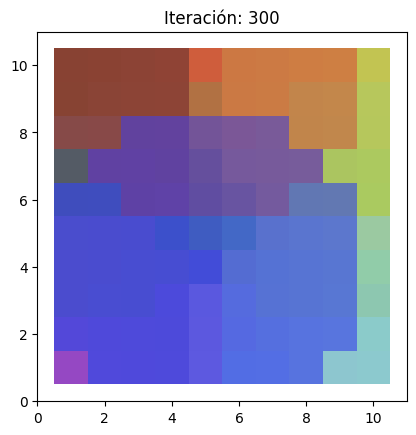

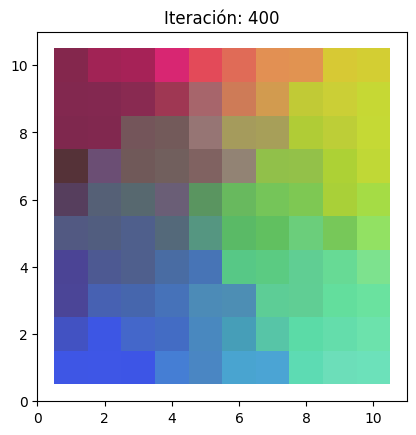

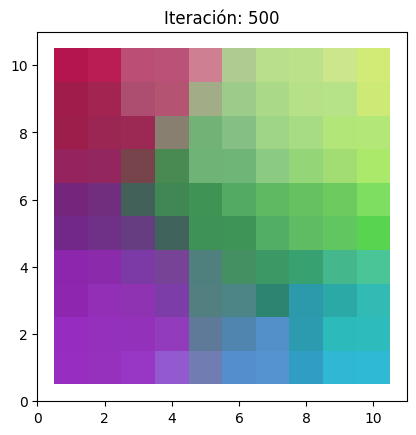

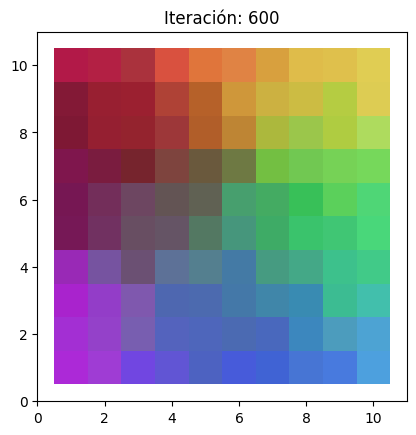

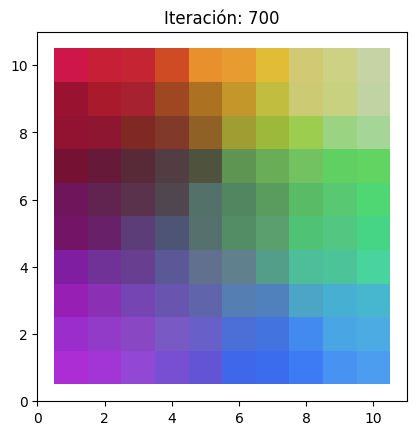

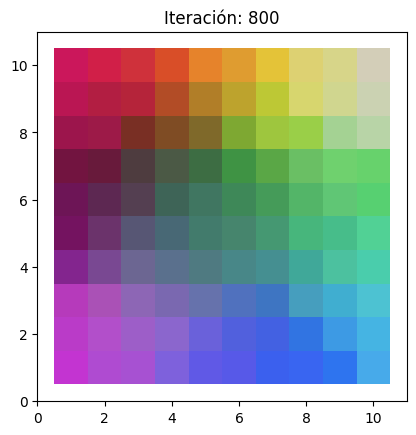

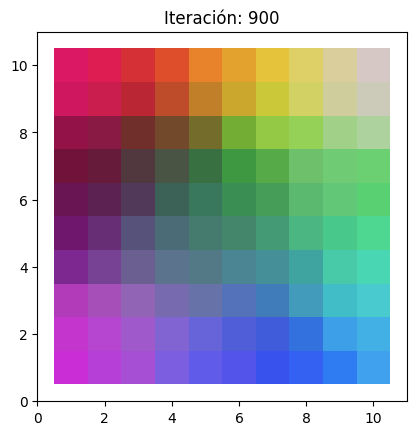

Error medio: 0.124434

Combinación 6/105
Lado: 10, Periodo: 2000, Learning Rate: 0.1


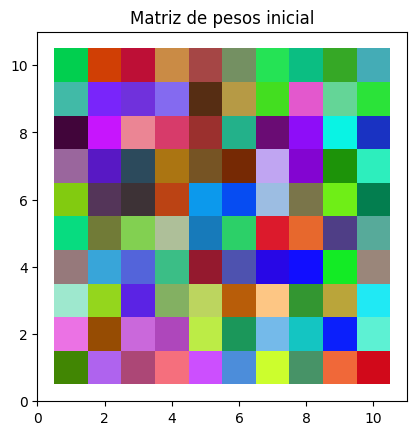

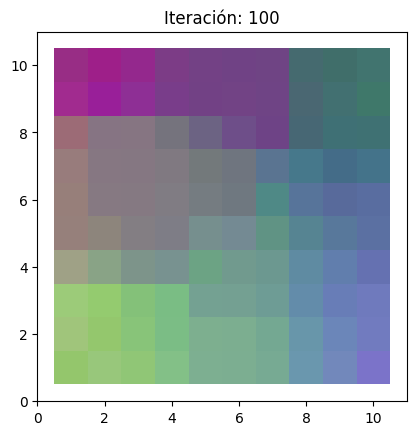

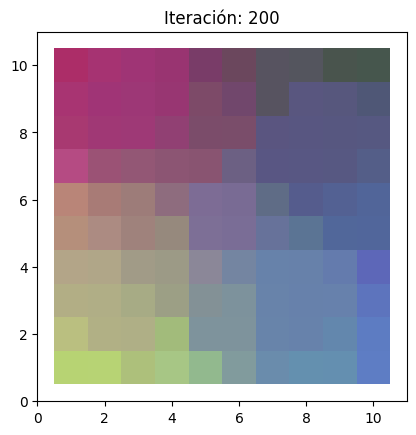

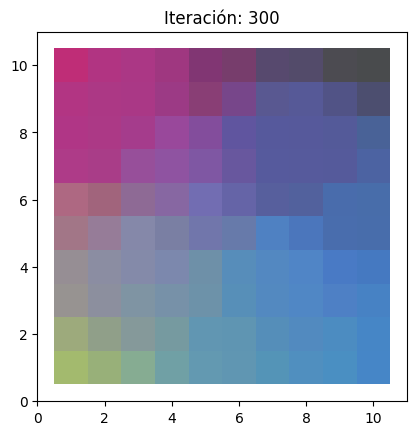

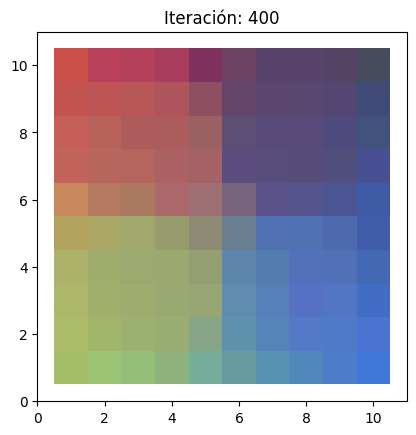

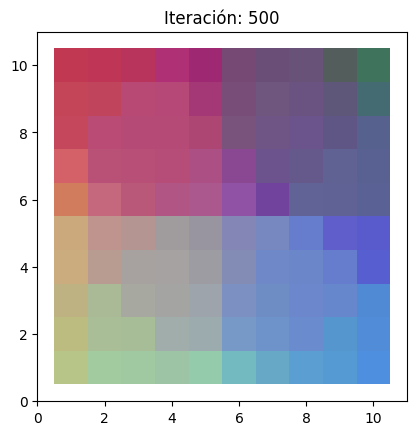

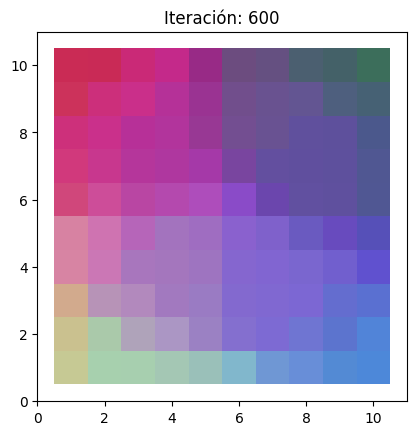

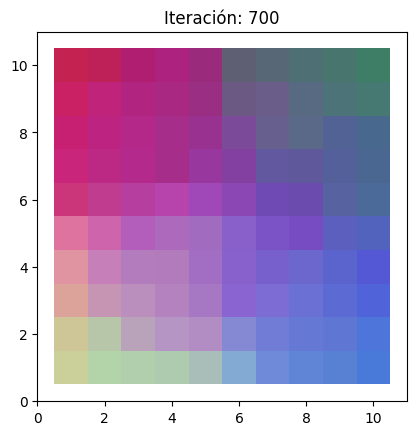

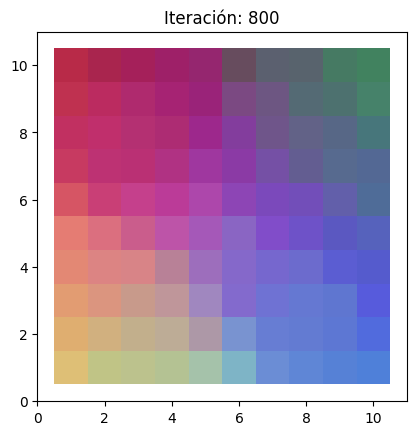

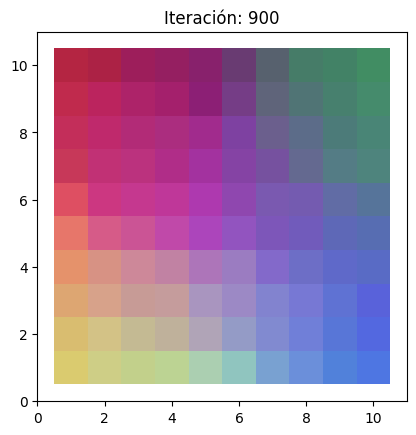

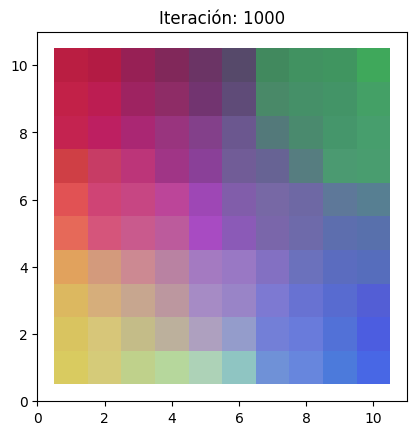

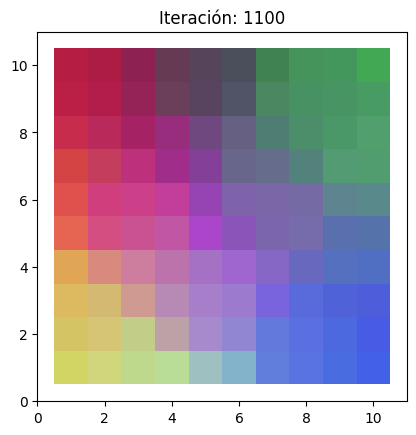

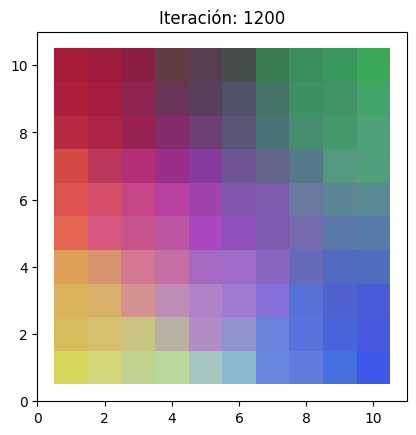

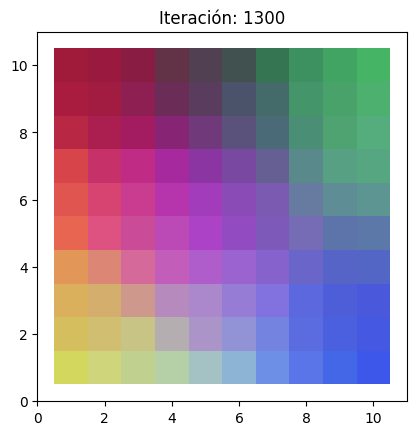

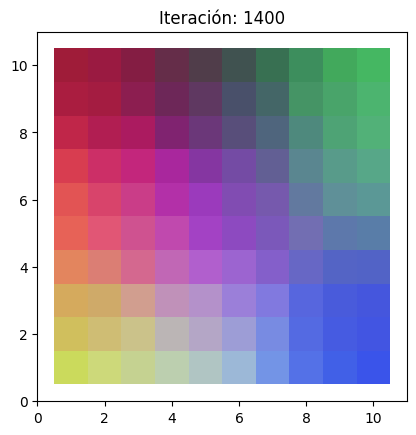

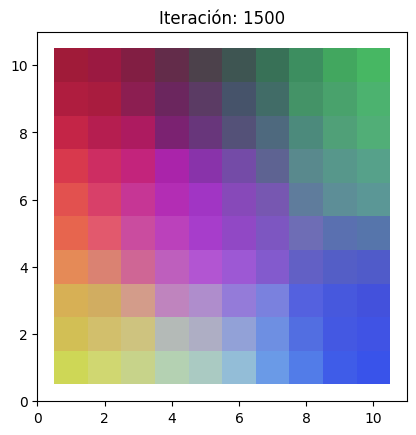

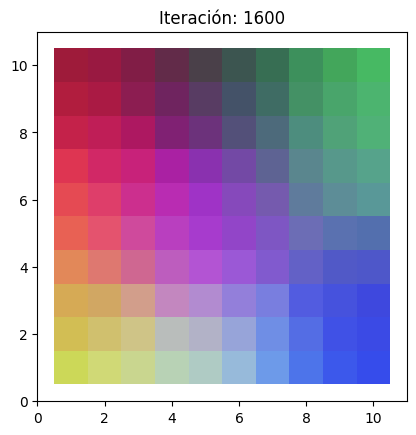

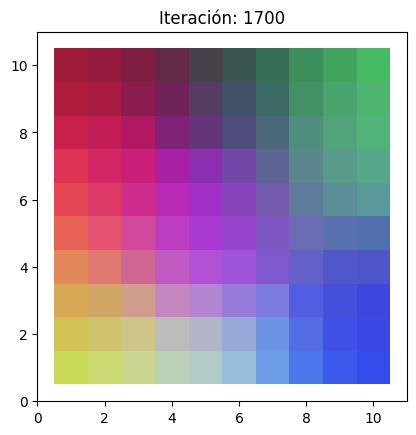

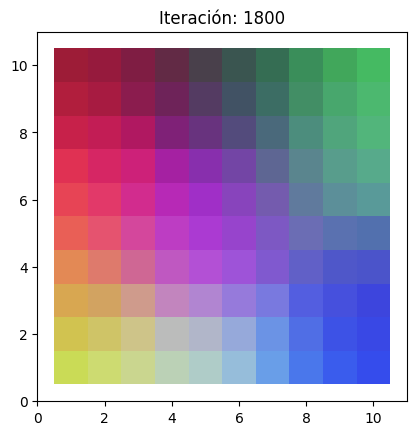

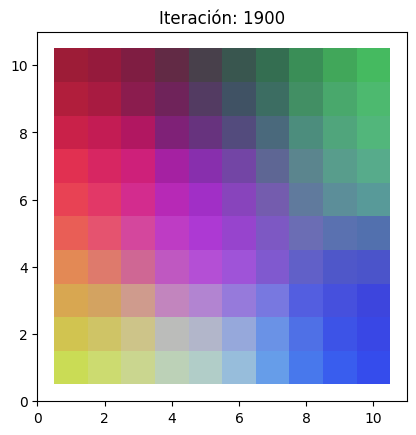

Error medio: 0.138814

Combinación 7/105
Lado: 10, Periodo: 2000, Learning Rate: 0.2


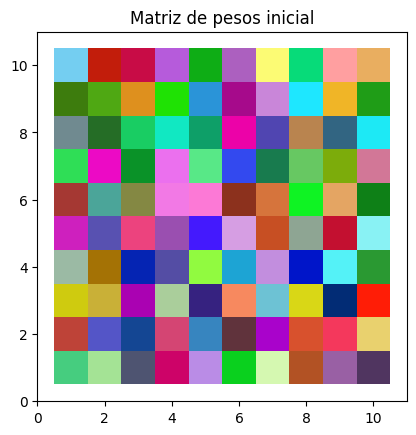

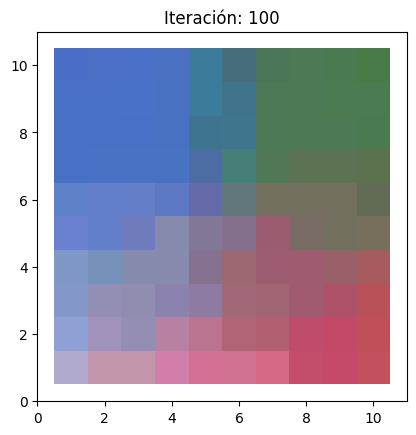

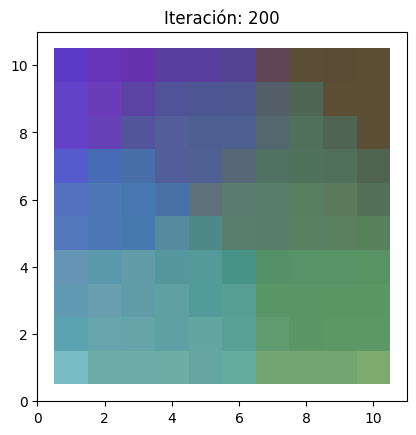

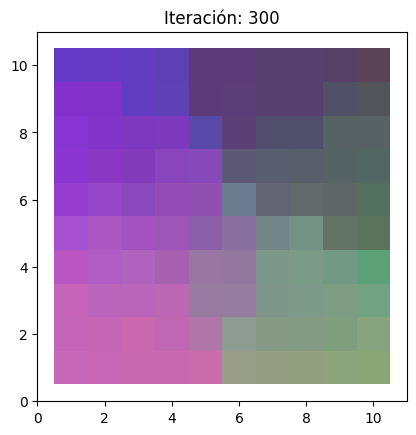

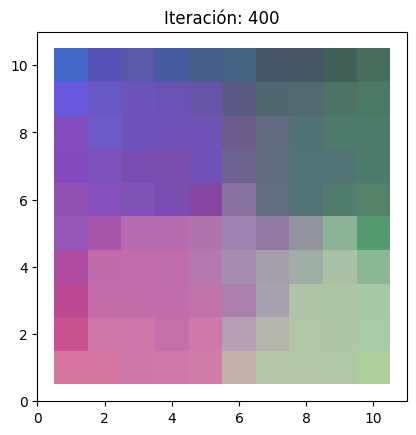

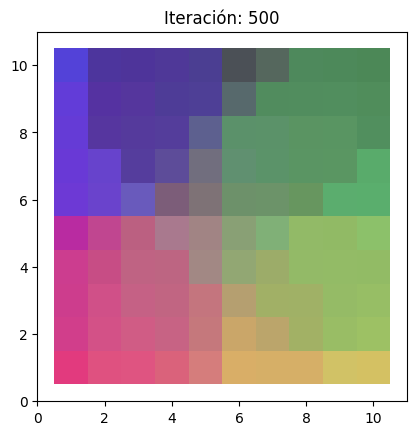

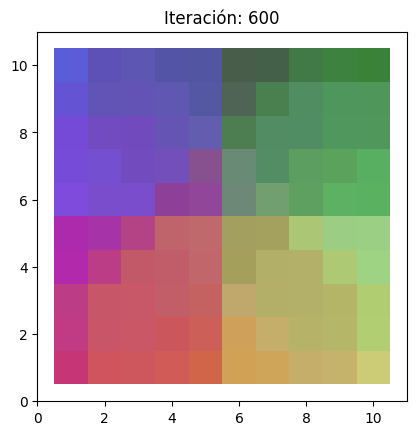

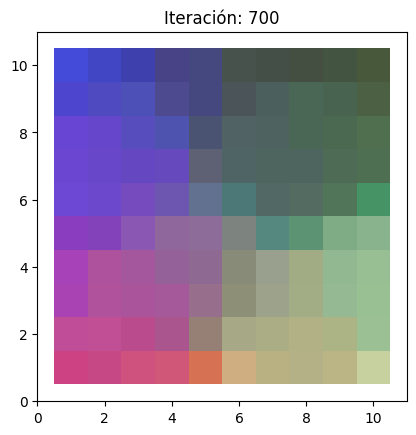

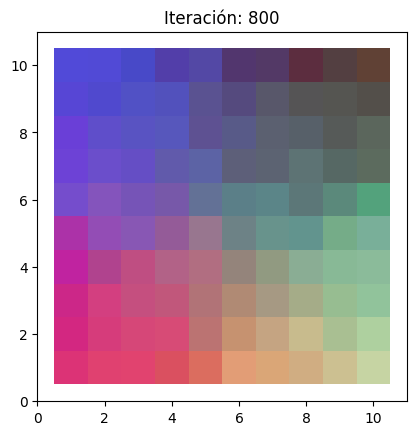

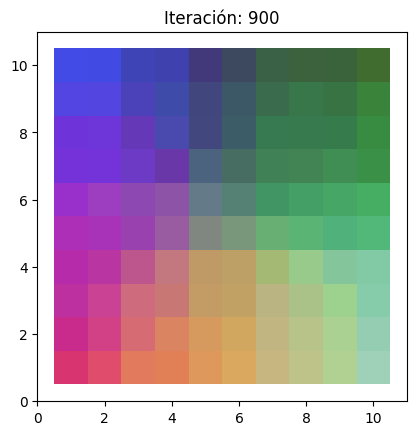

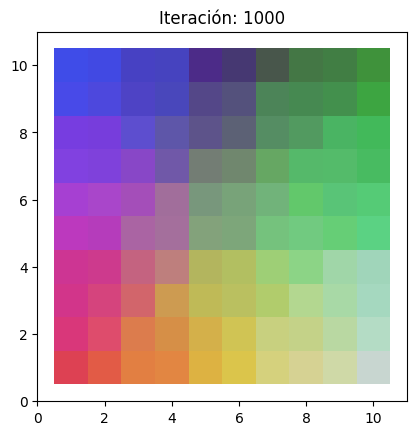

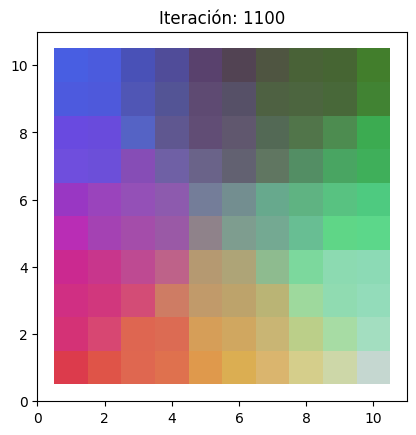

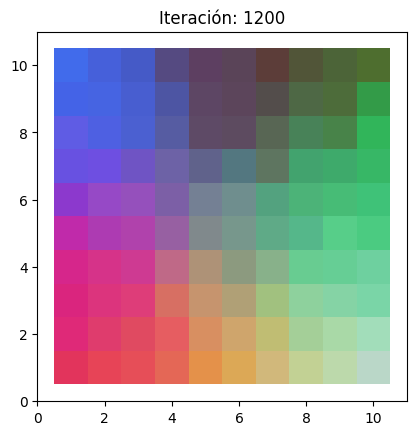

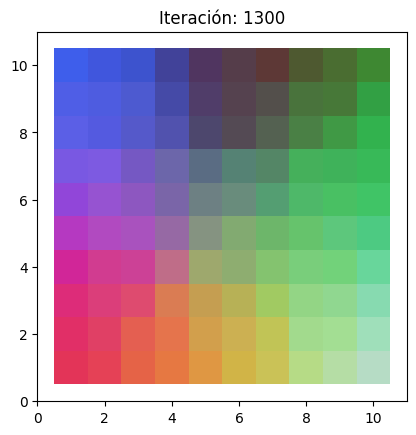

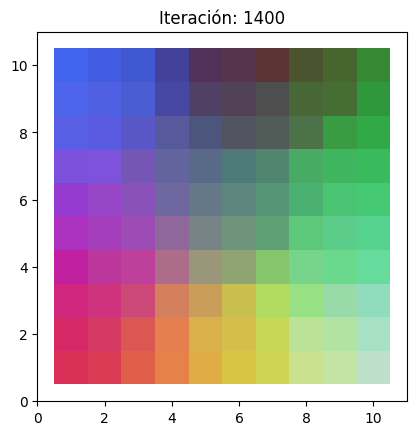

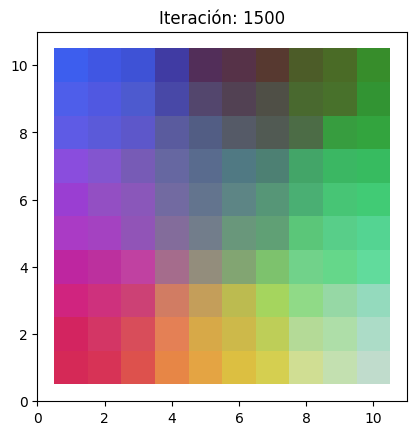

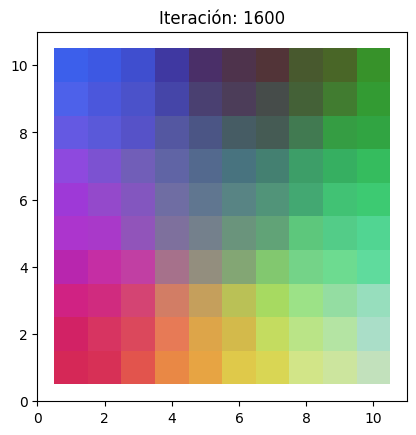

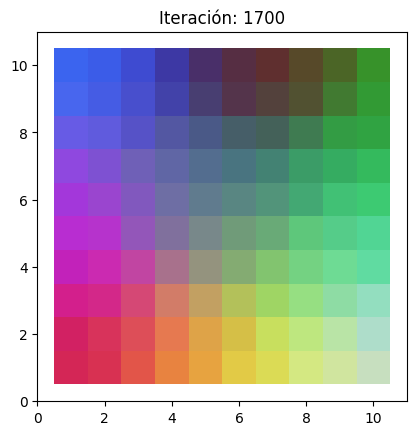

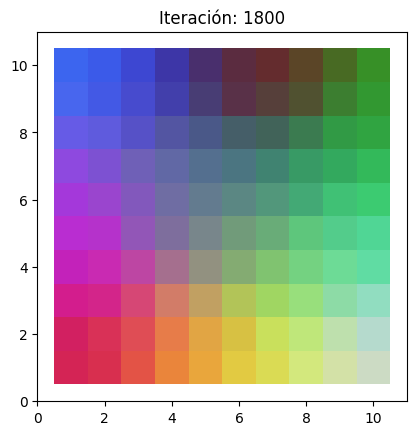

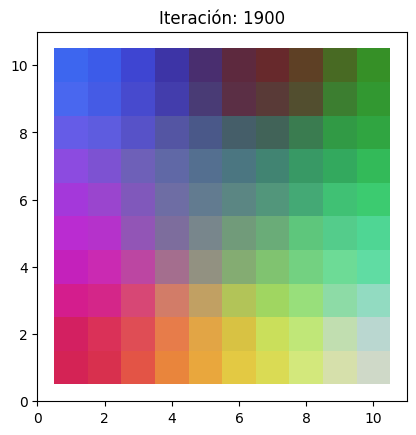

Error medio: 0.126955

Combinación 8/105
Lado: 10, Periodo: 2000, Learning Rate: 0.3


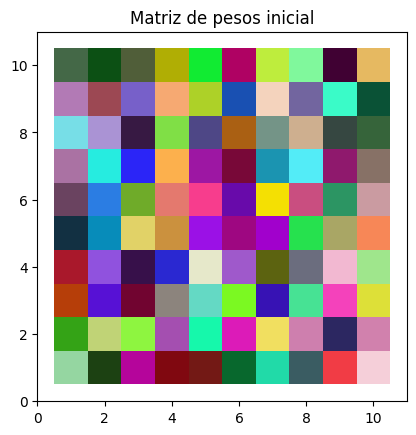

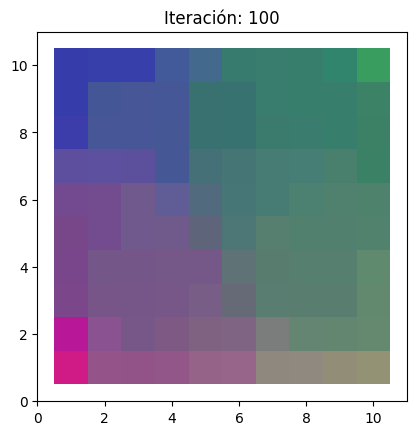

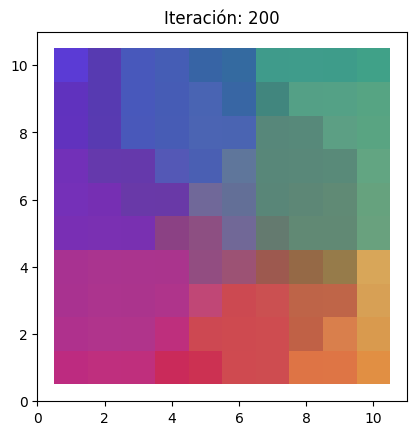

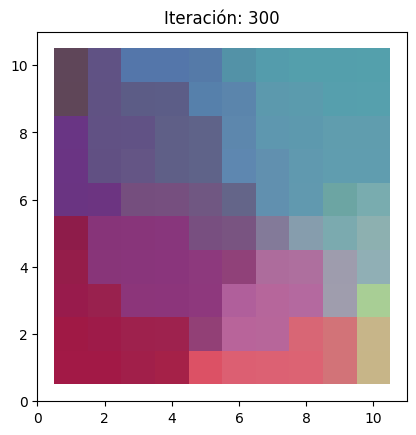

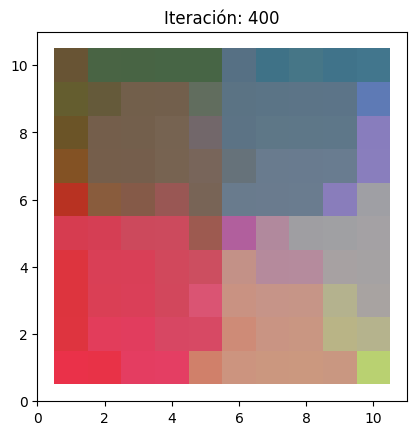

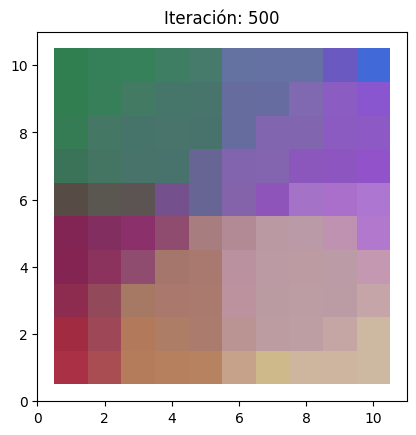

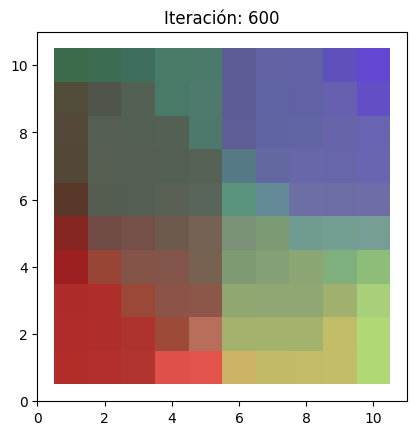

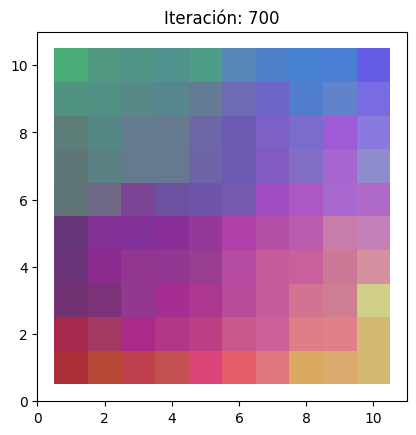

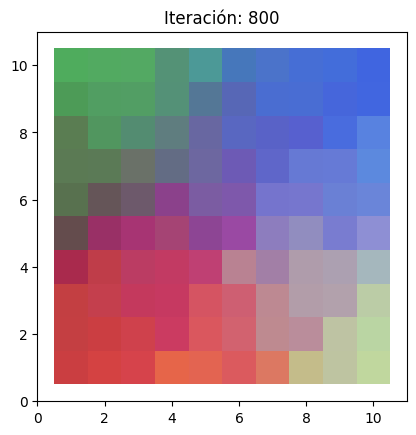

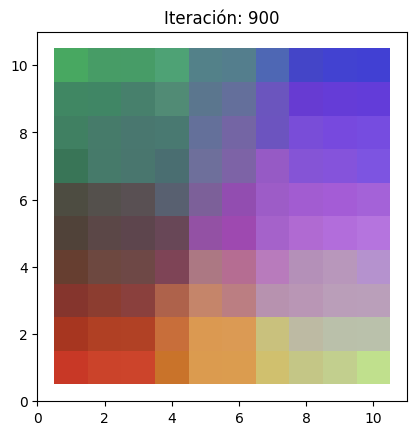

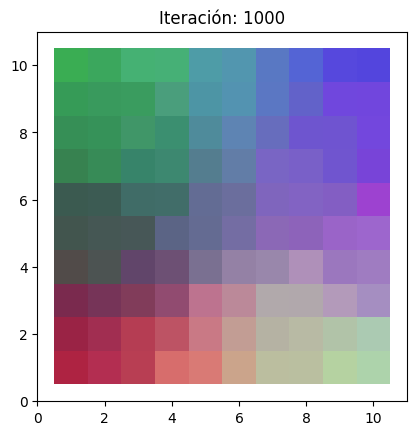

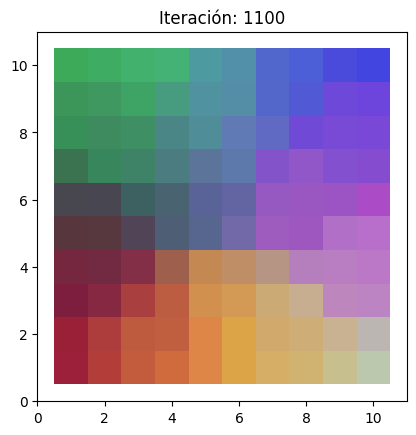

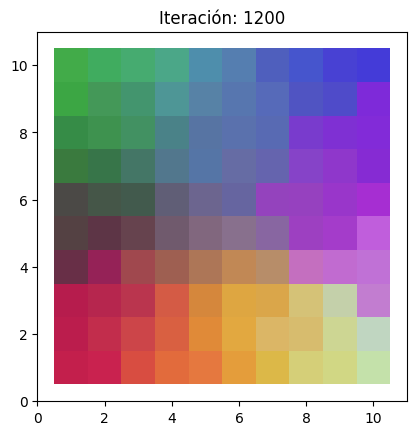

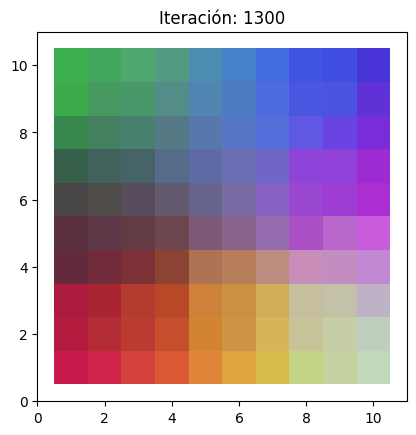

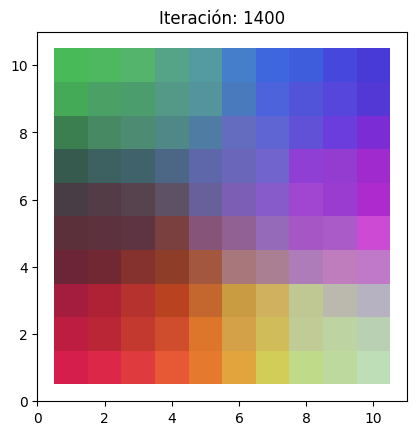

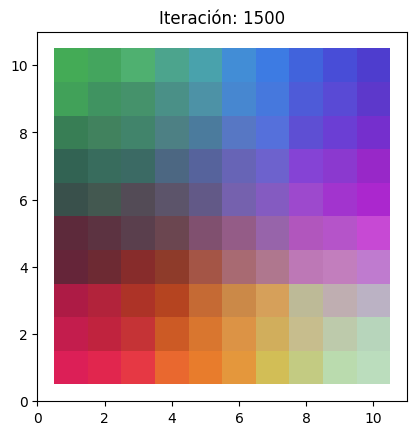

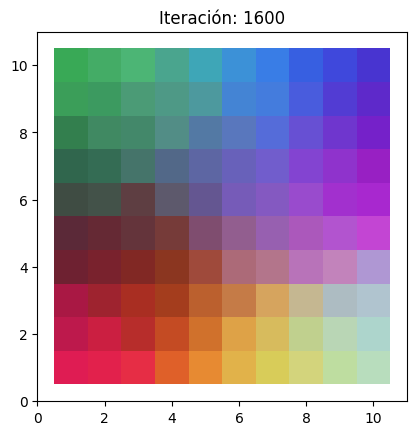

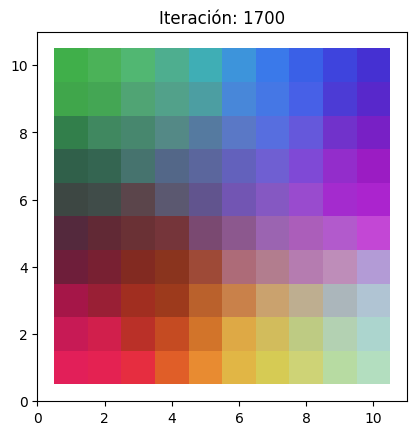

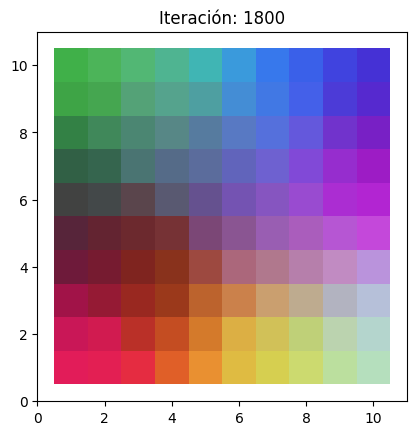

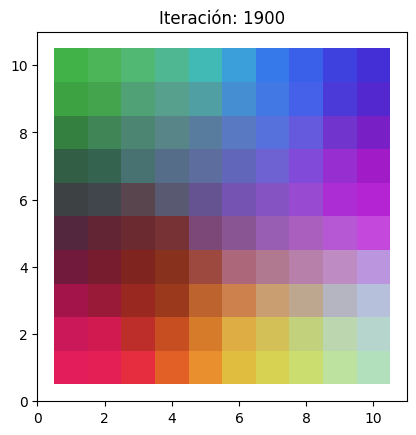

Error medio: 0.124344

Combinación 9/105
Lado: 10, Periodo: 2000, Learning Rate: 0.4


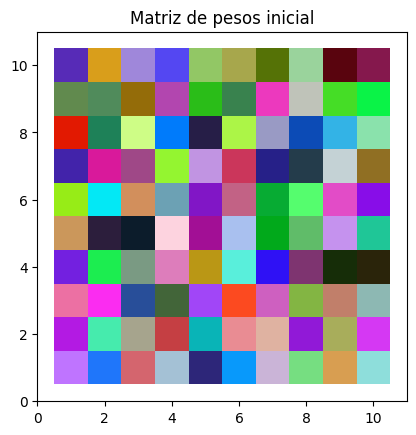

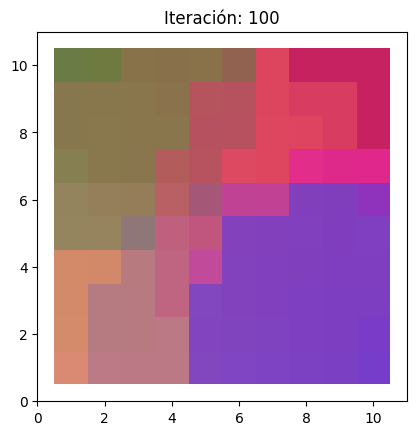

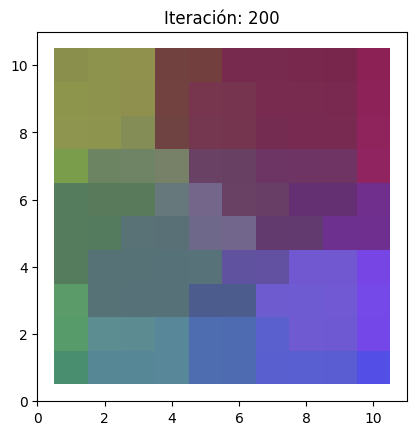

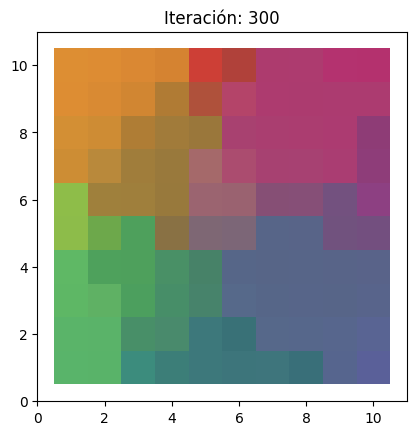

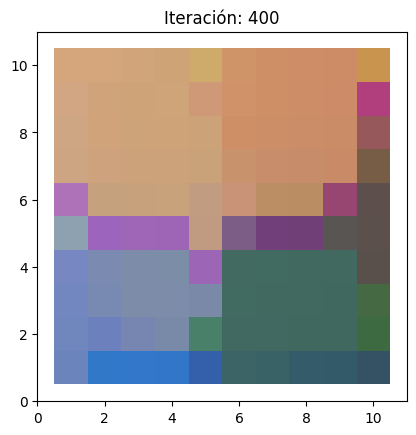

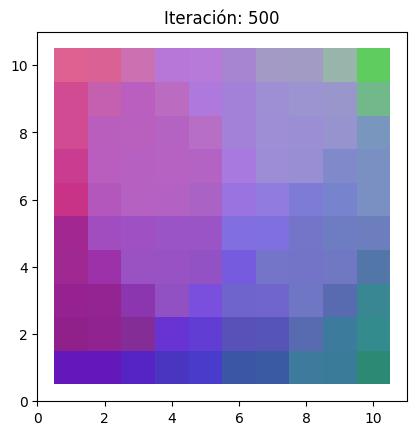

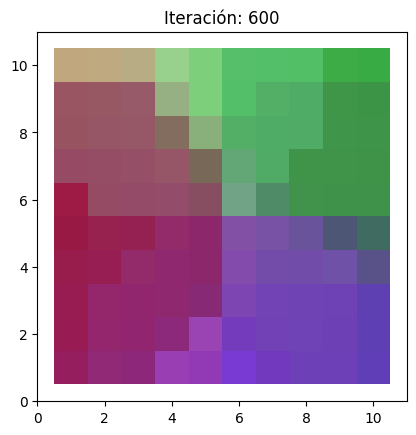

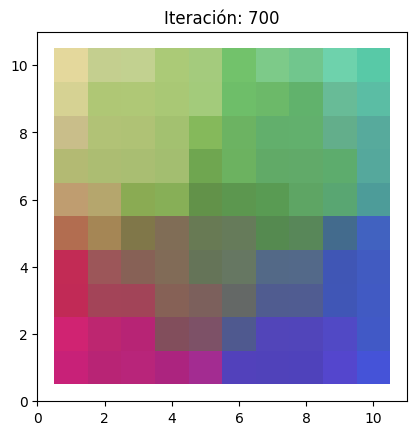

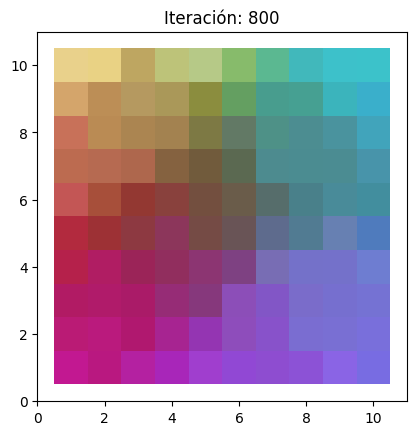

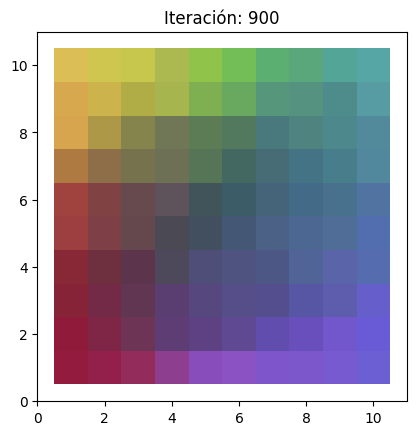

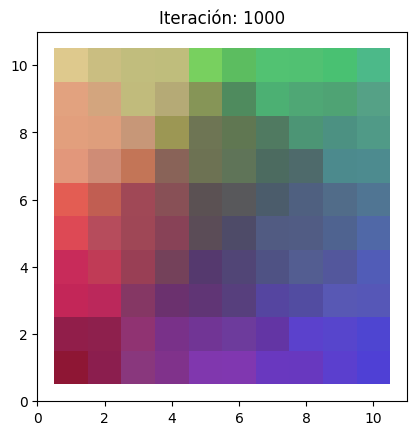

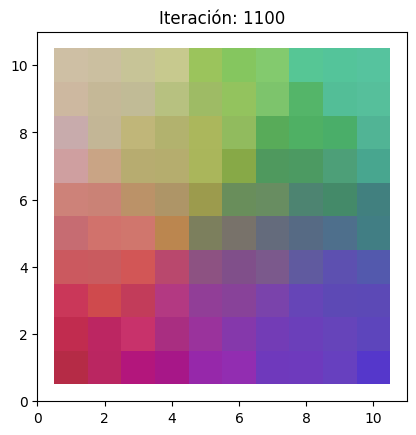

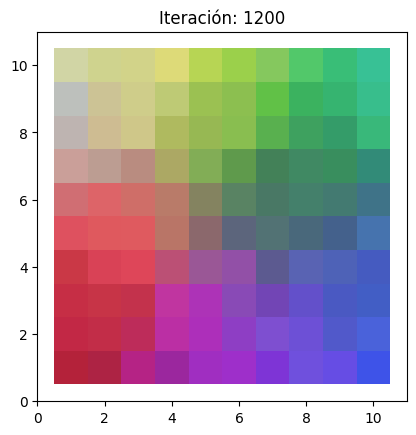

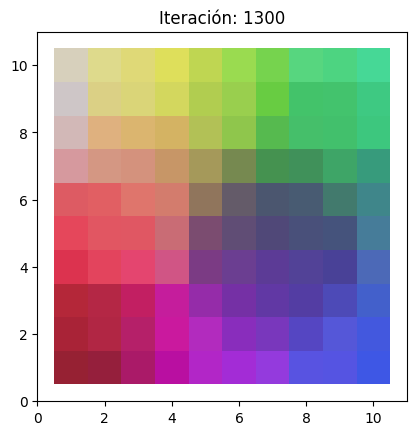

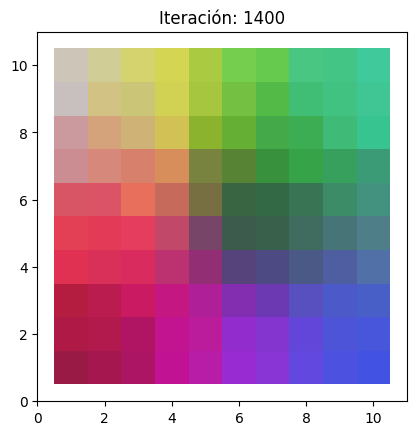

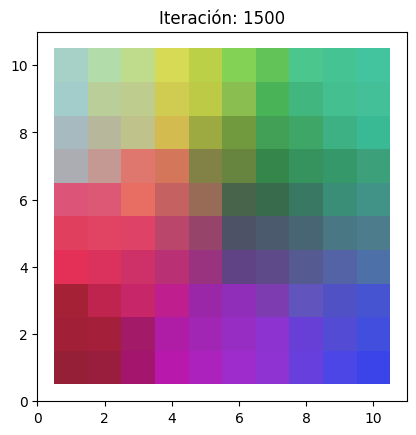

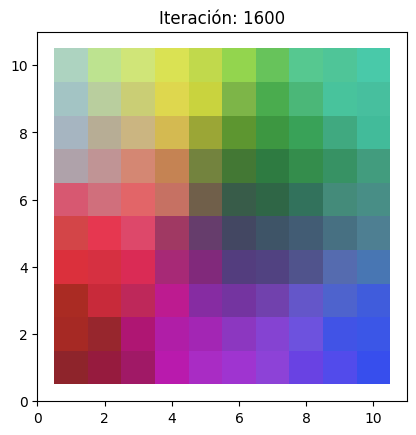

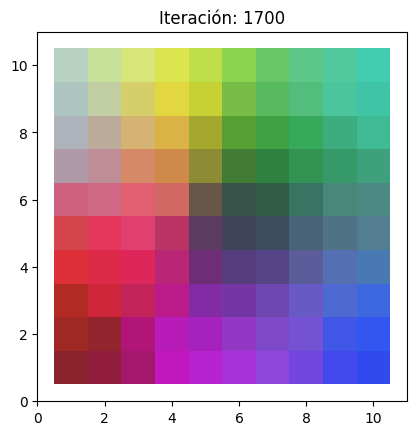

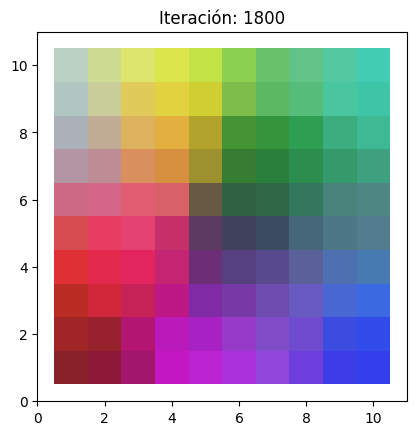

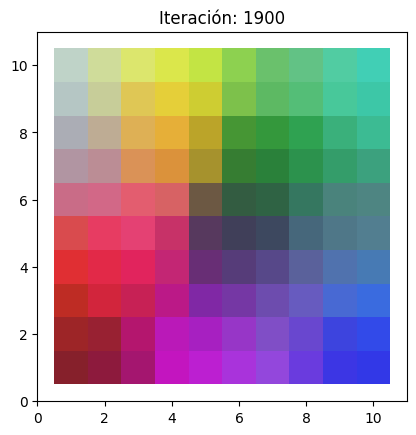

Error medio: 0.115766

Combinación 10/105
Lado: 10, Periodo: 2000, Learning Rate: 0.5


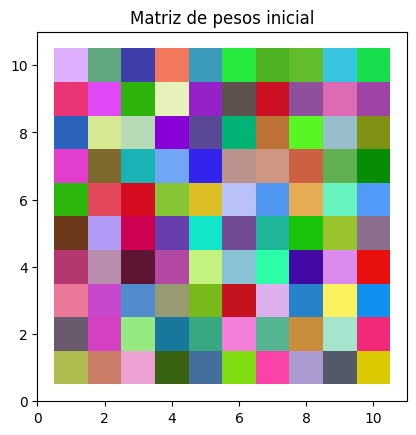

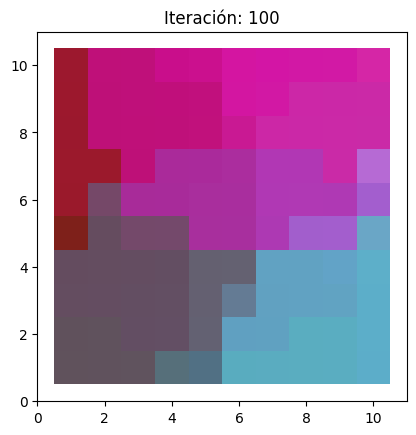

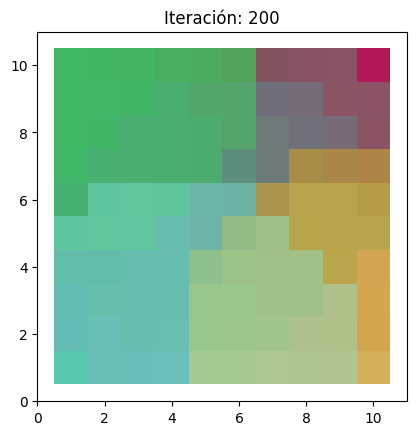

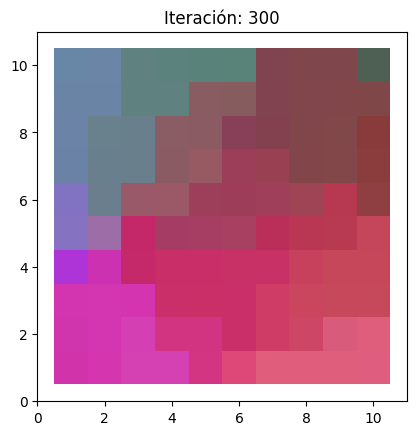

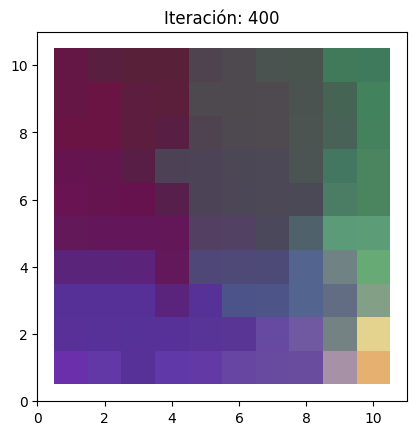

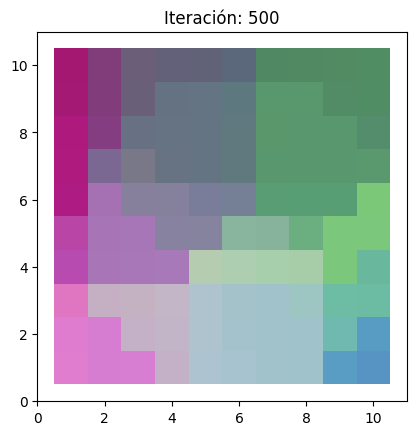

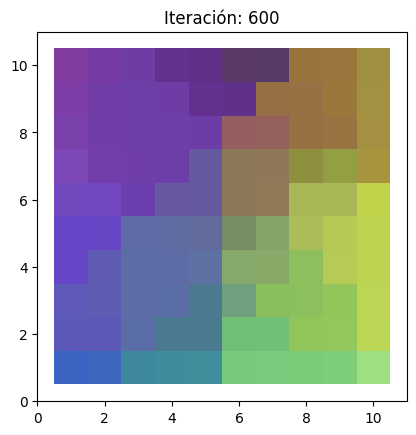

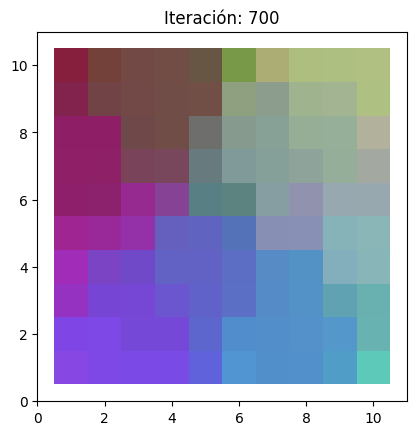

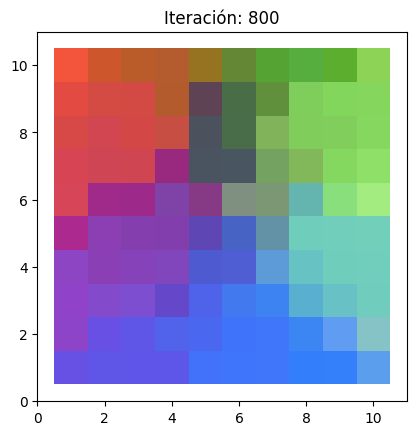

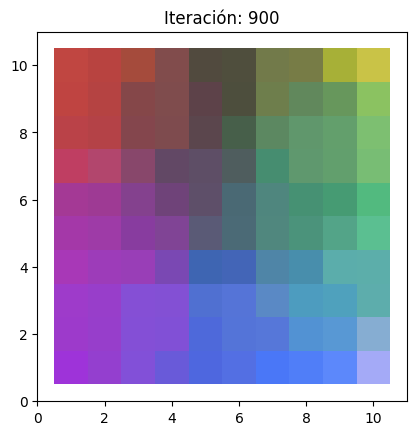

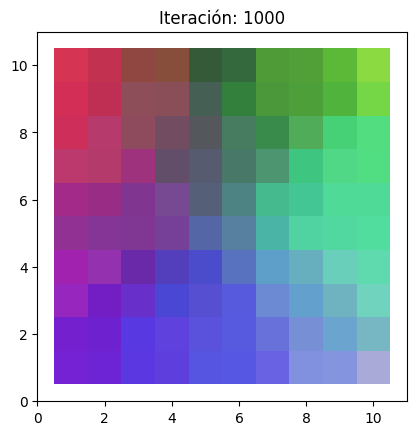

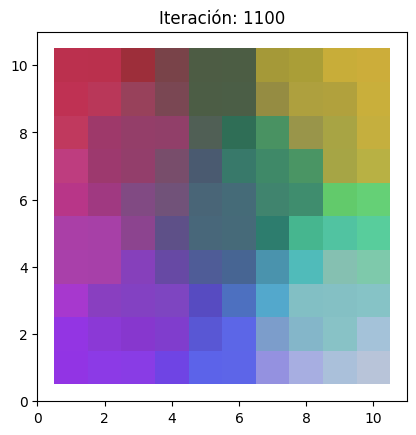

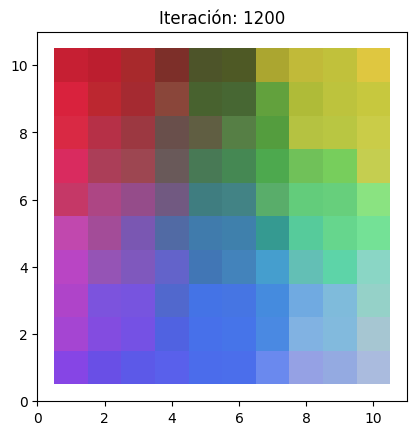

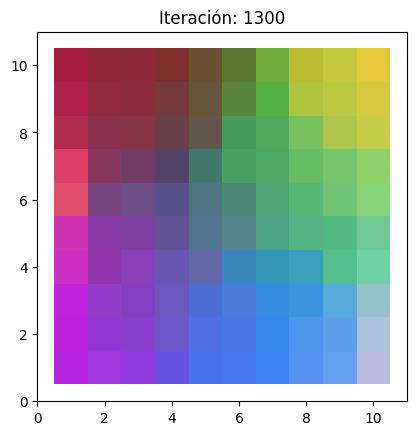

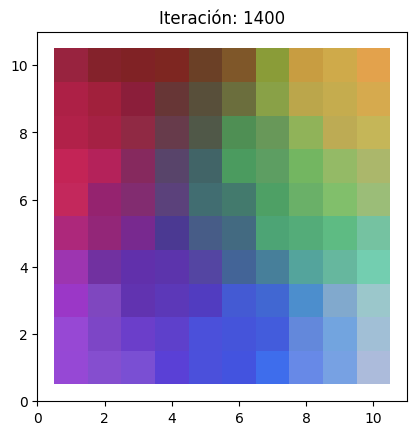

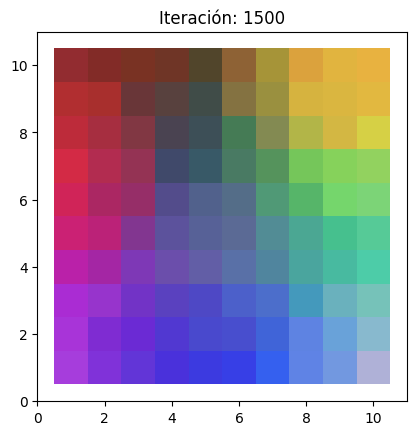

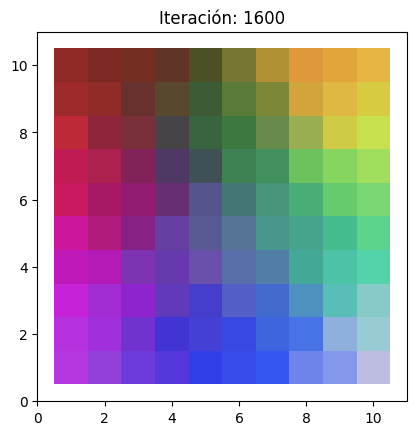

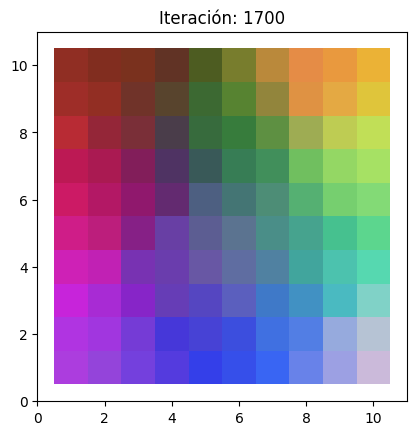

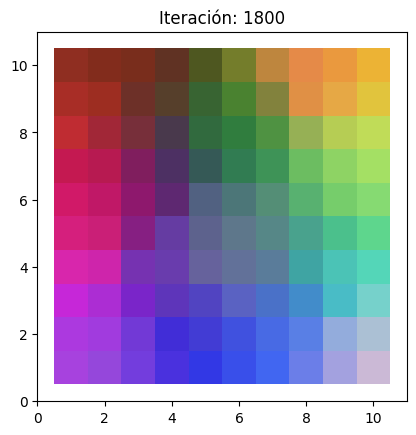

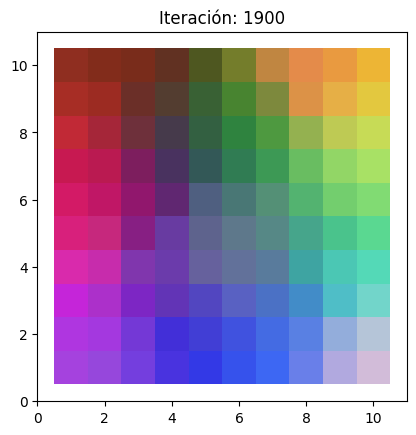

Error medio: 0.115969

Combinación 11/105
Lado: 10, Periodo: 3000, Learning Rate: 0.1


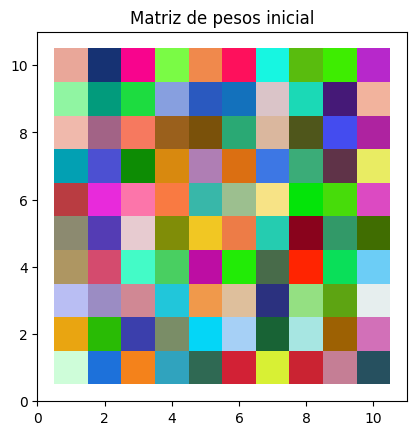

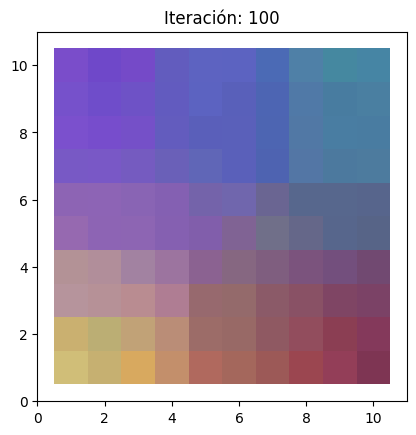

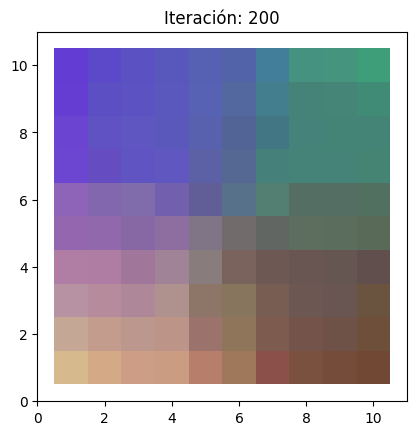

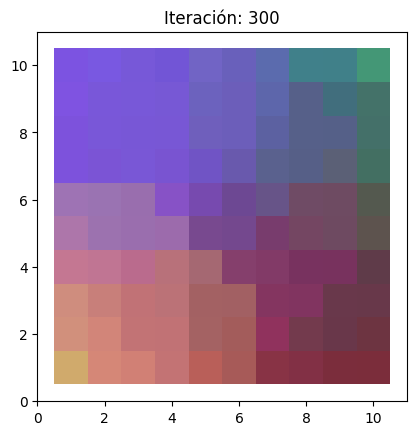

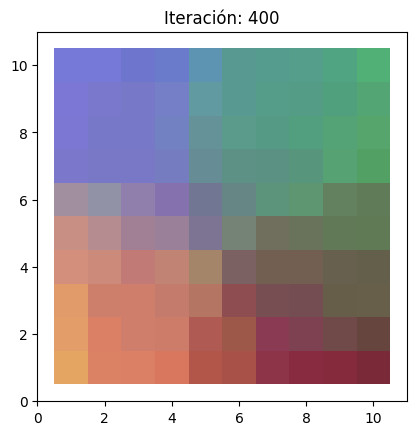

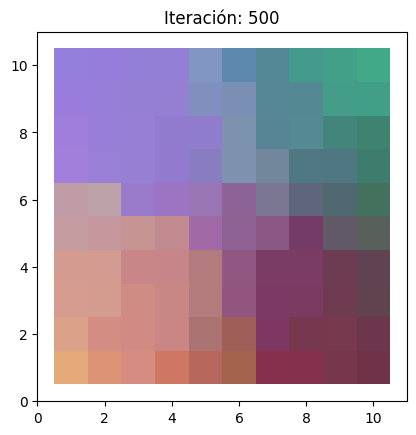

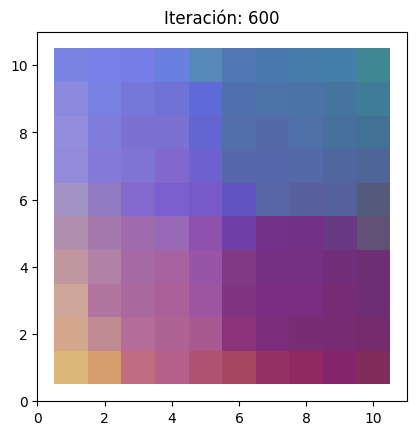

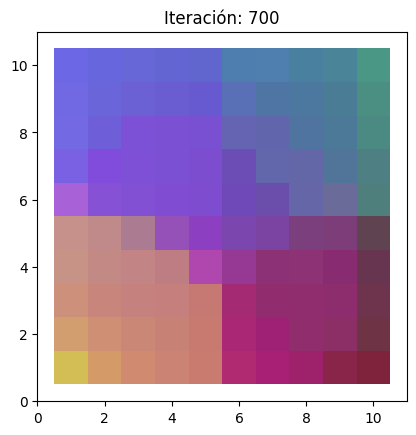

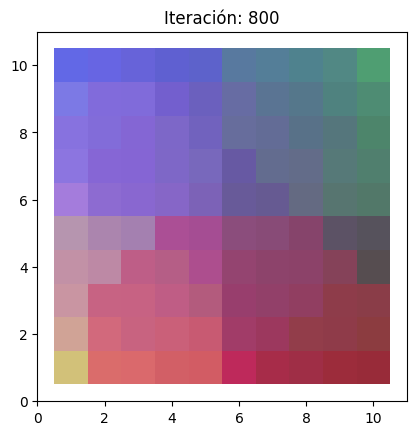

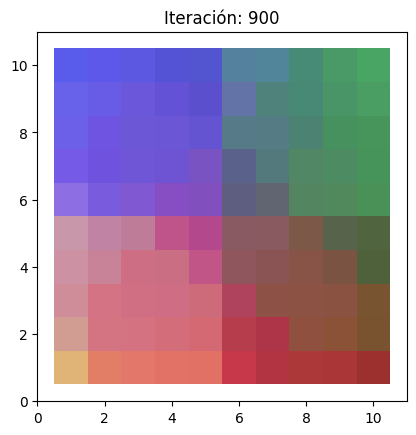

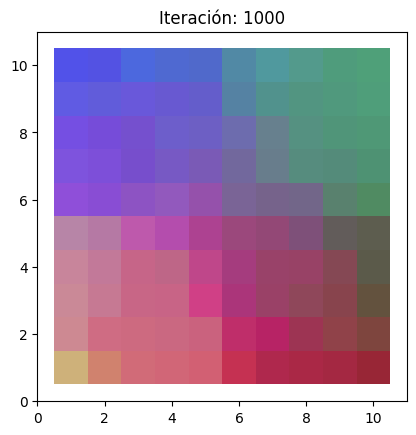

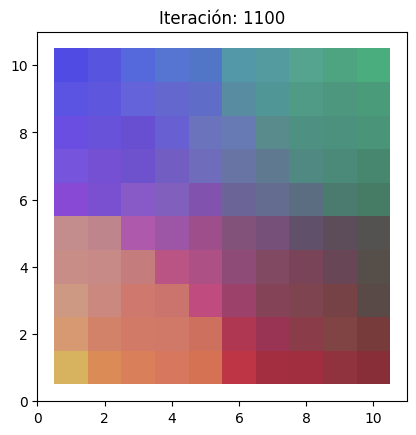

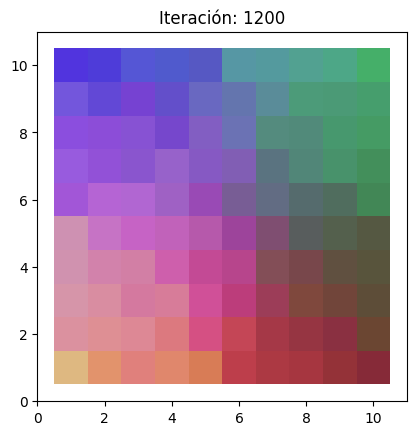

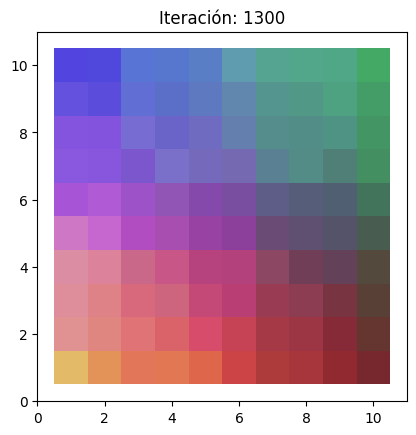

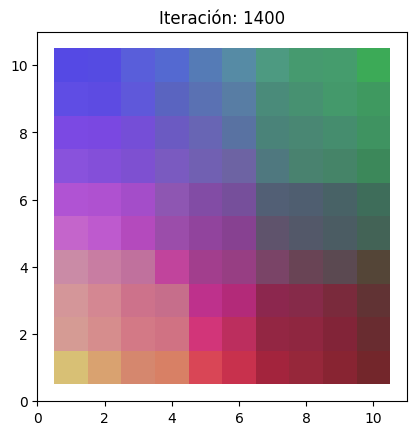

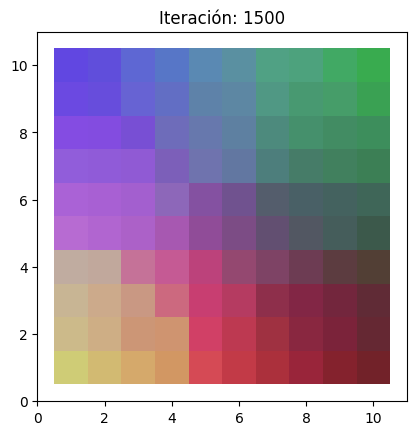

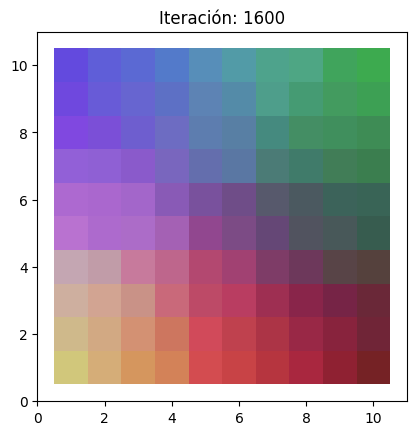

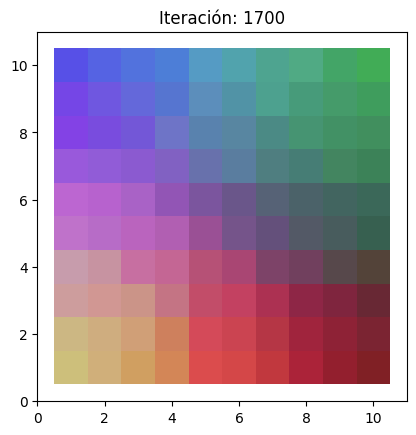

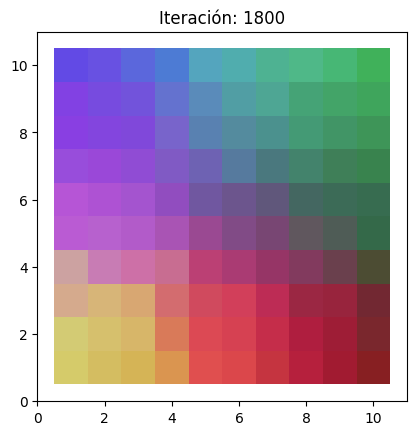

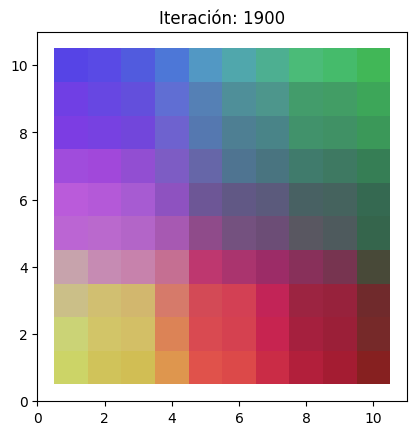

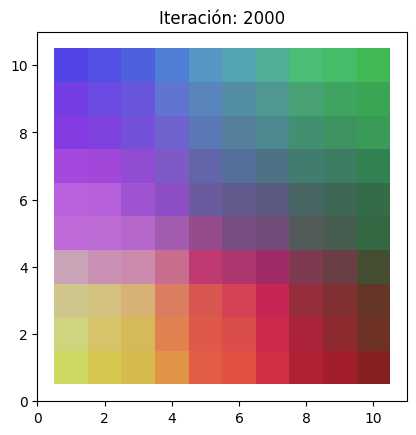

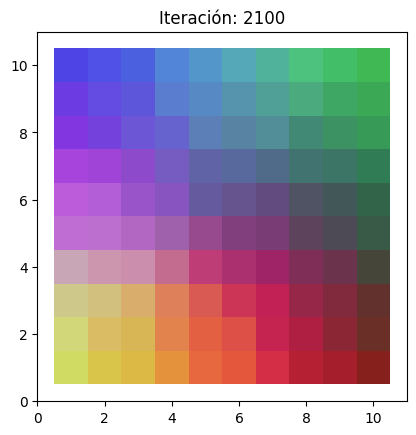

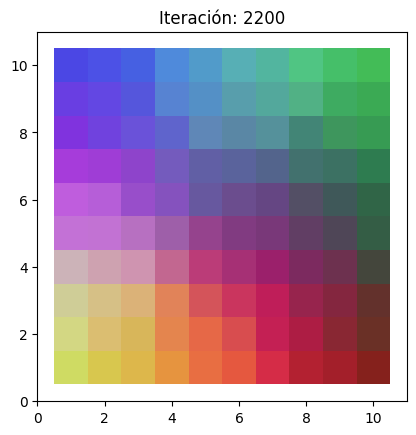

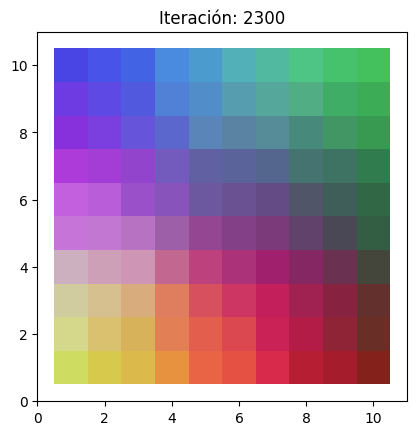

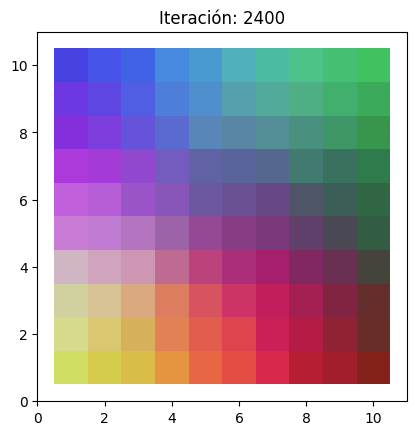

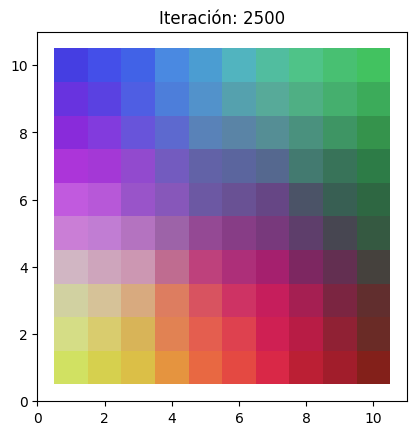

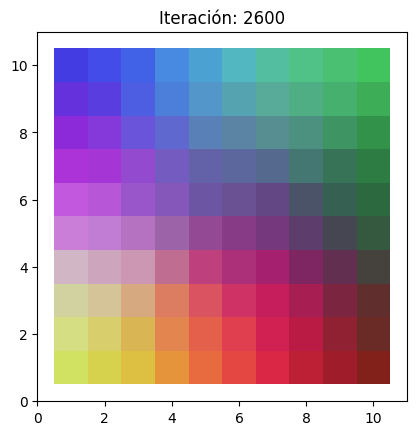

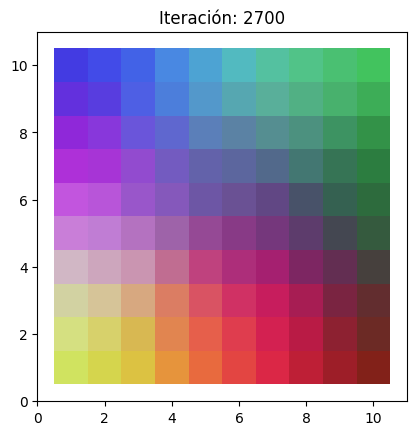

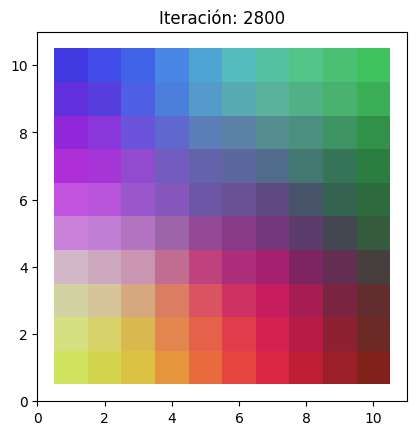

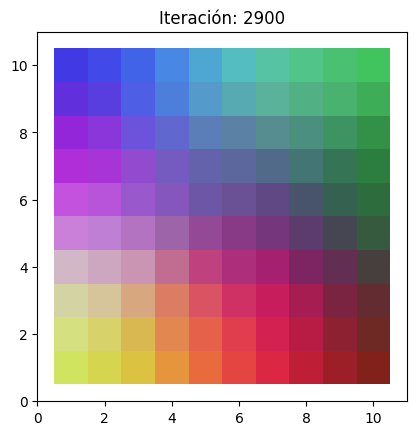

Error medio: 0.128089

Combinación 12/105
Lado: 10, Periodo: 3000, Learning Rate: 0.2


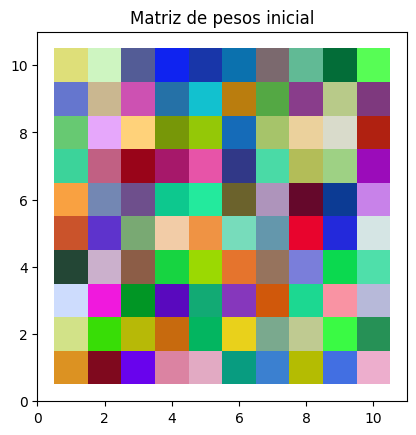

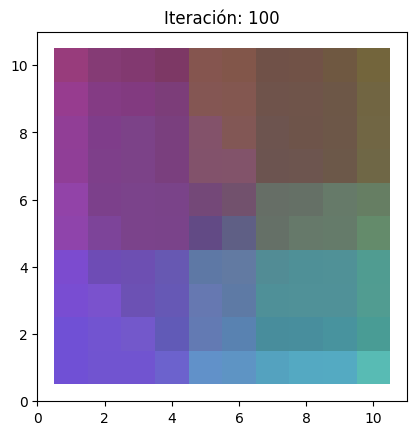

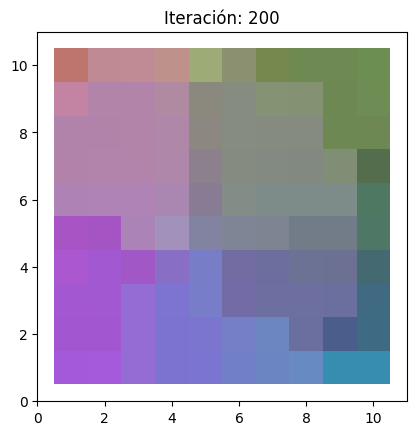

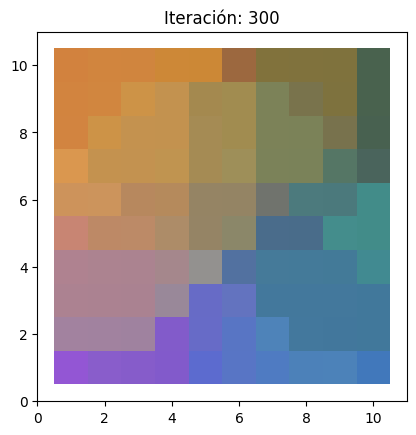

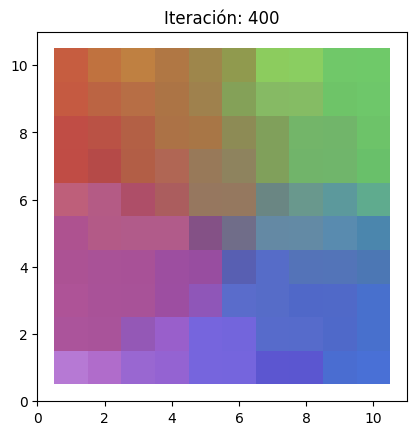

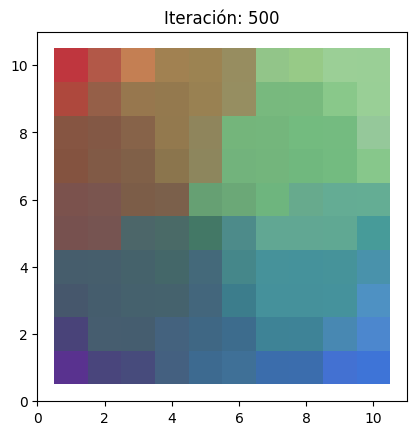

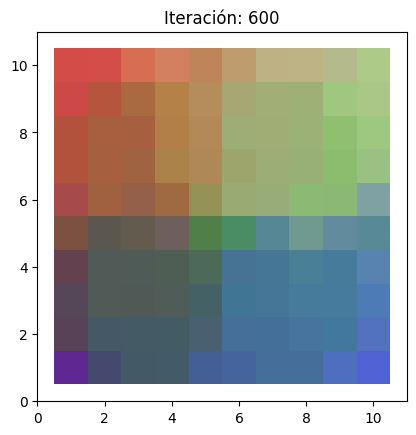

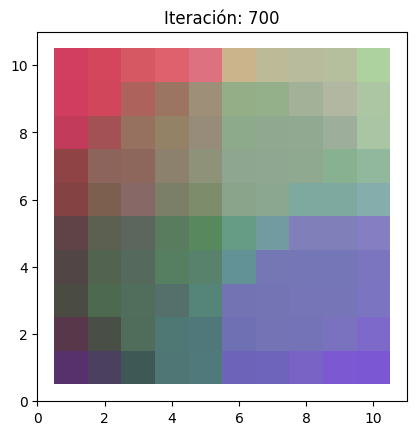

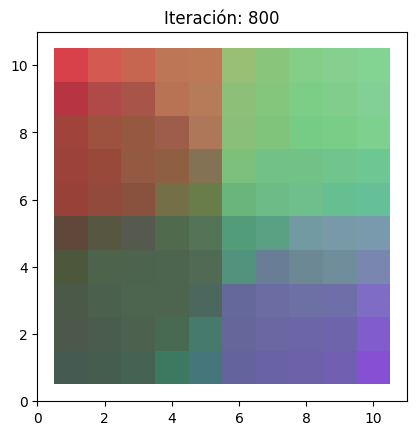

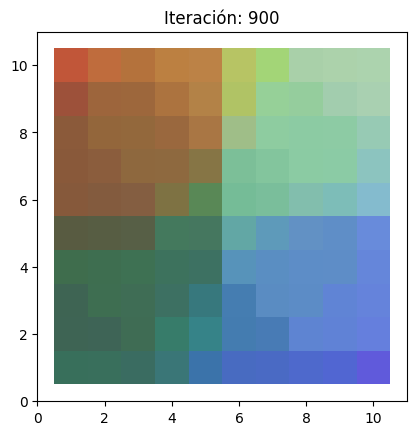

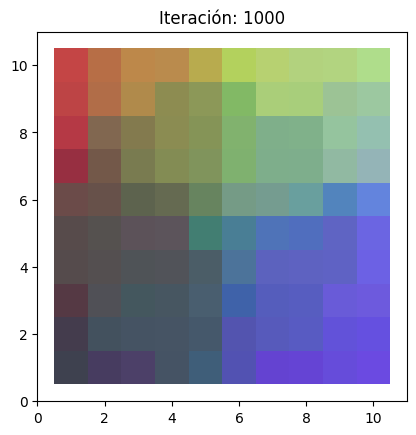

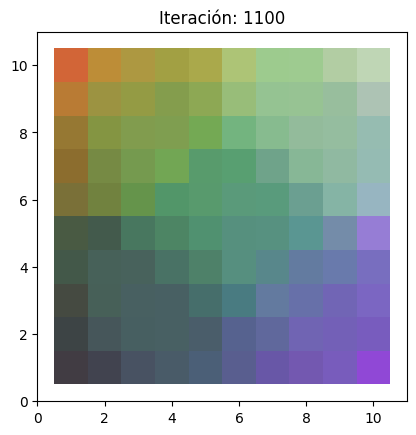

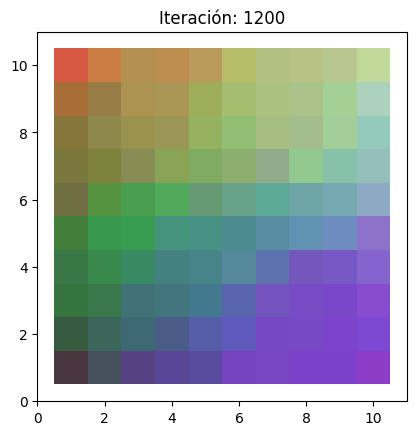

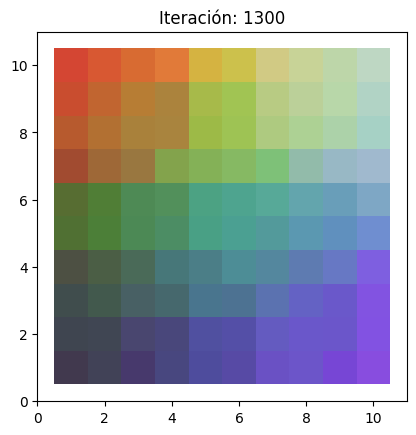

KeyboardInterrupt: 

In [ ]:
from itertools import product

def evaluar_parametros_som(datos, num_datos, num_entradas):
    """Evalúa diferentes combinaciones de parámetros para encontrar los óptimos
    usando rangos automáticos

    Args:
        datos: Datos de entrada (3 x num_datos)
        num_datos: Número de datos de entrada
        num_entradas: Dimensionalidad de los datos de entrada (3 para RGB)

    Returns:
        _type_: _description_
    """

    # Definimos los rangos de parámetors que vamos a evaluar
    rangos_parametros = {
        'lado_mapa': [10, 20, 30],  # 3 valores
        'periodo': list(range(1000, 7001, 1000)),
        'learning_rate': [round(x/10, 1) for x in range(1, 6)]
    }

    print("--- Rangos a evaluar: ---")
    print(f"Lados del mapa: {list(rangos_parametros['lado_mapa'])}")
    print(f"Periodos: {list(rangos_parametros['periodo'])}")
    print(f"Learning rates: {rangos_parametros['learning_rate']}")

    # Guardamos los resultados
    resultados = []

    #  Vamos a calcular cuantas combinaciones de parámetros vamos a probar
    total_combinaciones = (len(list(rangos_parametros['lado_mapa'])) *
                            len(list(rangos_parametros['periodo'])) *
                            len(rangos_parametros['learning_rate']))

    print(f"\n Vamos a evaluar {total_combinaciones} combinaciones de parámetros...")

    # Iteramos sobre todas las combinaciones de parámetros
    for indice, (lado, periodo, learning_rate) in enumerate(product(
                                                    rangos_parametros['lado_mapa'],
                                                    rangos_parametros['periodo'],
                                                    rangos_parametros['learning_rate']), 1):

        print(f"\nCombinación {indice}/{total_combinaciones}")
        print(f"Lado: {lado}, Periodo: {periodo}, Learning Rate: {learning_rate}")

        # Inicializamos la matriz de pesos y el vecindario
        matriz_pesos = np.random.random((lado, lado, num_entradas))
        vecindario = lado // 2

        # Entrenamos el SOM
        matriz_pesos_final = matriz_pesos.copy()
        entrenar_datos(matriz_pesos_final,
                        periodo,
                        datos,
                        num_datos,
                        num_entradas,
                        learning_rate,
                        vecindario)

        # Calculamos el error de cuantificación
        error_total = 0
        for dato in range(num_datos):
            patron = datos[:, dato]
            _, bmu_idx = calcular_bmu(patron, matriz_pesos_final, num_entradas)
            error = np.linalg.norm(patron - matriz_pesos_final[bmu_idx[0], bmu_idx[1]])
            error_total += error

        error_cuantificacion = error_total / num_datos

        print(f"Error medio/cuantificación: {error_cuantificacion:.6f}")

        # Calculamos el error topológico
        errores_topologicos = 0
        for i in range(num_datos):
            patron = datos[:, i]

            # Primera BMU
            _, bmu1_idx = calcular_bmu(patron, matriz_pesos_final, num_entradas)

            # Guardamos y modificamos temporalmente la primera BMU
            valor_bmu1 = matriz_pesos_final[int(bmu1_idx[0]), int(bmu1_idx[1])].copy()
            matriz_pesos_final[int(bmu1_idx[0]), int(bmu1_idx[1])] = float('inf')

            # Segunda BMU
            _, bmu2_idx = calcular_bmu(patron, matriz_pesos_final, num_entradas)

            # Restauramos el valor original
            matriz_pesos_final[int(bmu1_idx[0]), int(bmu1_idx[1])] = valor_bmu1

            # Verificamos si son adyacentes
            distancia = np.linalg.norm(bmu1_idx - bmu2_idx)
            if distancia > np.sqrt(2):  # No son adyacentes
                errores_topologicos += 1

        error_topologico = errores_topologicos / num_datos

        print(f"Error topológico: {error_topologico:.6f}")

        # Guardamos resultados
        resultados.append({
            'lado_mapa': lado,
            'periodo': periodo,
            'learning_rate': learning_rate,
            'error_cuantificacion': error_cuantificacion,
            'error_topologico': error_topologico
        })

        print(f"Error de cuantificación: {error_cuantificacion:.6f}")
        print(f"Error topológico: {error_topologico:.6f}")

    # Modificamos la selección del mejor resultado
    mejor_resultado = min(resultados, key=lambda x: x['error_cuantificacion'])

    # Visualizamos los resultados
    visualizar_resultados(resultados)

    return mejor_resultado


def visualizar_resultados(resultados):
    """Visualiza los resultados de la búsqueda de parámetros

    Args:
        resultados: Resultados a visualizar
    """
    resultados_array = np.array([(r['lado_mapa'], r['periodo'],
                                r['learning_rate'], r['error_cuantificacion'],
                                r['error_topologico'])
                                for r in resultados])

    fig = plt.figure(figsize=(15, 5))

    # Gráfico 1: Lado vs Error Cuantificación
    ax1 = fig.add_subplot(231)
    for lr in np.unique(resultados_array[:, 2]):
        mask = resultados_array[:, 2] == lr
        ax1.plot(resultados_array[mask, 0],
                resultados_array[mask, 3],
                'o-',
                label=f'LR={lr}')
    ax1.set_xlabel('Lado del Mapa')
    ax1.set_ylabel('Error de Cuantificación')
    ax1.legend()
    ax1.grid(True)

    # Gráfico 2: Periodo vs Error Cuantificación
    ax2 = fig.add_subplot(232)
    for lr in np.unique(resultados_array[:, 2]):
        mask = resultados_array[:, 2] == lr
        ax2.plot(resultados_array[mask, 1],
                resultados_array[mask, 3],
                'o-',
                label=f'LR={lr}')
    ax2.set_xlabel('Periodo')
    ax2.set_ylabel('Error de Cuantificación')
    ax2.legend()
    ax2.grid(True)

    # Gráfico 3: Learning Rate vs Error Cuantificación
    ax3 = fig.add_subplot(233)
    for lado in np.unique(resultados_array[:, 0]):
        mask = resultados_array[:, 0] == lado
        ax3.plot(resultados_array[mask, 2],
                resultados_array[mask, 3],
                'o-',
                label=f'Lado={int(lado)}')
    ax3.set_xlabel('Learning Rate')
    ax3.set_ylabel('Error de cuantificación')
    ax3.legend()
    ax3.grid(True)

    # Gráfico 4: Lado vs Error Topológico
    ax4 = fig.add_subplot(234)
    for lr in np.unique(resultados_array[:, 2]):
        mask = resultados_array[:, 2] == lr
        ax4.plot(resultados_array[mask, 0],
                resultados_array[mask, 4],
                'o-',
                label=f'LR={lr}')
    ax4.set_xlabel('Lado del Mapa')
    ax4.set_ylabel('Error Topológico')
    ax4.legend()
    ax4.grid(True)

    # Gráfico 5: Periodo vs Error Topológico
    ax5 = fig.add_subplot(235)
    for lr in np.unique(resultados_array[:, 2]):
        mask = resultados_array[:, 2] == lr
        ax5.plot(resultados_array[mask, 1],
                resultados_array[mask, 4],
                'o-',
                label=f'LR={lr}')
    ax5.set_xlabel('Periodo')
    ax5.set_ylabel('Error Topológico')
    ax5.legend()
    ax5.grid(True)

    # Gráfico 6: Learning Rate vs Error Topológico
    ax6 = fig.add_subplot(236)
    for lado in np.unique(resultados_array[:, 0]):
        mask = resultados_array[:, 0] == lado
        ax6.plot(resultados_array[mask, 2],
                resultados_array[mask, 4],
                'o-',
                label=f'Lado={int(lado)}')
    ax6.set_xlabel('Learning Rate')
    ax6.set_ylabel('Error Topológico')
    ax6.legend()
    ax6.grid(True)

    plt.tight_layout()
    plt.show()

mejor_resultado = evaluar_parametros_som(datos, num_datos, num_entradas)

print("\nMejores parámetros encontrados:")
print(f"Lado del mapa: {mejor_resultado['lado_mapa']}")
print(f"Periodo: {mejor_resultado['periodo']}")
print(f"Learning rate: {mejor_resultado['learning_rate']}")
print(f"Error de cuantificación: {mejor_resultado['error_cuantificacion']:.6f}")
print(f"Error topológico: {mejor_resultado['error_topologico']:.6f}")

# Guardamos los mejores parámetros para su uso posterior
parametros_optimos = {
    'lado_mapa': mejor_resultado['lado_mapa'],
    'periodo': mejor_resultado['periodo'],
    'learning_rate': mejor_resultado['learning_rate'],
    'vecindario': mejor_resultado['lado_mapa'] // 2
}

## SOM Clasificación

In [ ]:
# Clasifica los patrones de entrenamiento con la matriz de pesos recién entrenada


## SOM Prueba

In [ ]:
# Clasifica nuevos patrones

